In [91]:

import os
import json
import warnings

import numpy as np
import iohinspector as ins 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import polars as pl

from time import perf_counter
from scipy import stats



import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 15})

data = "../../data/"
files = [f for f in os.listdir(data)]
one_plus_one = [os.path.join(data, f) for f in files if f.startswith("One") and not f.endswith("zip")]
mu_comma = [os.path.join(data, f) for f in files if f.startswith("Mu") and not f.endswith("zip")]
cma_es = [os.path.join(data, f) for f in files if f.startswith("CMA-ES-UN") and not f.endswith("zip")]
cma_es_sob = [os.path.join(data, f) for f in files if f.startswith("CMA-ES-SOB") and not f.endswith("zip")]
ecma_es = [os.path.join(data, f) for f in files if f.startswith("eCMA-ES") and not f.endswith("zip")]
recma_es = [os.path.join(data, f) for f in files if f.startswith("re-eCMA-ES") and not f.endswith("zip")]
reecma_es = [os.path.join(data, f) for f in files if f.startswith("re-eCMA-ES") and not f.endswith("zip")]
len(one_plus_one), len(mu_comma), len(cma_es), 

# cma_es_sob = ['../../data/CMA-ES-UNIFORM-SCALED_UNIFORM',
#   '../../data/CMA-ES-UNIFORM-GAUSSIAN',] + cma_es_sob

def fix_legend_labels(ax, n_split, algs, groupby_word = None, reorder=False):
    colors = dict(zip(algs, mcolors.TABLEAU_COLORS))
    lines = ax.get_lines()[::]
    if reorder:
        lines = lines[::2] + lines[1::2]
        
    for line, line_label in zip(lines[:len(lines)//2], lines[len(lines)//2:]):
        if (lab:=line_label.get_label()) in colors:
            for l in (line, line_label):
                l.set_color(colors[lab])
                l.set_linewidth(3)  
                if groupby_word is not None and groupby_word in lab:
                    l.set_linestyle('dashed')  
                else:
                    l.set_linestyle('solid')  
            
    handles, labels = ax.get_legend_handles_labels()
    labels = [l[n_split:] for l in labels[:]]
    idx = np.argsort(labels)
    ax.legend(np.array(handles)[idx], np.array(labels)[idx], fancybox=True, shadow=True, fontsize=13)
    return handles, labels
    
def place_legend_below(ax, handles, labels, show = True, legend_nrow = 1, start_legend = 3, loc_y = -.11):
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
            box.width, box.height * 0.9])
    
    ax.legend().remove()
    if show:
        ax.legend(np.array(handles), np.array(labels), loc='upper center',
            fontsize=13, bbox_to_anchor=(start_legend, loc_y), fancybox=True, shadow=True, ncol=np.ceil(len(labels) / legend_nrow), 
            zorder=1000
        )
        
def get_manager(folders):
    manager = ins.DataManager()
    algs = []
    for alg in folders:
        algs.append(os.path.basename(alg))
        manager.add_folder(alg)
    algs.sort()
    
    return manager, algs

def make_ecdfs(folders, alg_name, file_name_prefix, n_split = 15, groupby_word=None, legend_nrow=1, dims=(2, 3, 5, 10, 20, 40), fids = None):
    manager, algs = get_manager(folders)
    
    if fids is None:
        fids = range(1, 25)
        
    for fid in fids:
        print(fid, end=',')
        f, axes = plt.subplots(1, len(dims), figsize=(20, 7), sharey=True)

        f.suptitle(f"{alg_name} on $f_{{{fid}}}$")
        for dim, ax in zip(dims, axes.ravel()):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                m = manager.select(function_ids=[fid], dimensions=[dim])
                
            dt = ins.plot.plot_ecdf(m.load(True, True), ax=ax)

            ax.set_title(f"${dim}D$")
            ax.set_ylabel("Fraction Attained")
            h,l = fix_legend_labels(ax, n_split, algs, groupby_word)
            place_legend_below(ax, h, l, dim == 2, legend_nrow)
                
        plt.savefig(f"figures/{file_name_prefix}_f{fid}.pdf")

def plot_ecdf_agg_dims(folders,alg_name, file_name_prefix, n_split = 15, groupby_word="", legend_nrow=1, dims = (2, 3, 5, 10, 20, 40), fids = None):
    manager, algs = get_manager(folders)
    if fids is None:
        fids = range(1, 25)
        
    f, axes = plt.subplots(1, len(dims), figsize=(5*len(dims), 7), sharey=True)
    for ax, dim in zip(axes, dims):
        for alg in algs:
            m = manager.select(algorithms=[alg], dimensions=[dim], function_ids = fids)
            dt = ins.plot.plot_ecdf(m.load(True, True), ax=ax)
        
        h,l = fix_legend_labels(ax, n_split, algs, groupby_word, reorder=True)
        place_legend_below(ax,h,l, dim == 2, start_legend=.5 + (.5 * len(dims)), legend_nrow=legend_nrow)
        ax.set_title(f"${dim}D$")
        ax.set_ylabel("Fraction Attained")
        ax.grid()    
    f.suptitle(alg_name)        
    plt.savefig(f"figures/{file_name_prefix}_ecdf_agg_dim.pdf")   
    
def plot_ecdf_agg(folders, alg_name, file_name_prefix, n_split = 15, groupby_word="", legend_nrow=1, dims = (2, 3, 5, 10, 20, 40), fids = None):
    manager, algs = get_manager(folders)

    if fids is None:
        fids = range(1, 25)
        
    f, ax = plt.subplots(figsize=(8, 5))
    for alg in algs:
        m = manager.select(algorithms=[alg],  function_ids = fids, dimensions=dims)
        dt = ins.plot.plot_ecdf(m.load(True, True), ax=ax)

    h,l = fix_legend_labels(ax, n_split, algs, groupby_word, reorder=True)
    # place_legend_below(ax,h,l, dim == 2, start_legend=.5 + (.5 * len(dims)), legend_nrow=legend_nrow)
    ax.set_title(alg_name)
    ax.set_ylabel("Fraction Attained")
    ax.grid()    
    plt.savefig(f"figures/{file_name_prefix}_ecdf_agg.pdf") 
    
    
def calc_aocc(group, fval_col = "eaf", max_budget = 10_000 * 40):
    group = group.cast({"evaluations": pl.Int64}).filter(
        pl.col("evaluations") <= max_budget
    )
    new_row = pl.DataFrame(
        {
            "evaluations": [0, max_budget],
            fval_col: [group[fval_col].min(), group[fval_col].max()],
        }
    )
    group = (
        pl.concat([group, new_row], how="diagonal")
        .sort("evaluations")
        .fill_null(strategy="forward")
        .fill_null(strategy="backward")
    )
    return group.with_columns(
        (
            (
                pl.col("evaluations").diff(n=1, null_behavior="ignore")
                * (pl.col(fval_col).shift(1))
            )
            / max_budget
        ).alias("aocc_contribution")
    )['aocc_contribution'].sum()

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,

/tmp/ipykernel_3139447/3756588643.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axes = plt.subplots(1, len(dims), figsize=(20, 7), sharey=True)


22,23,24,

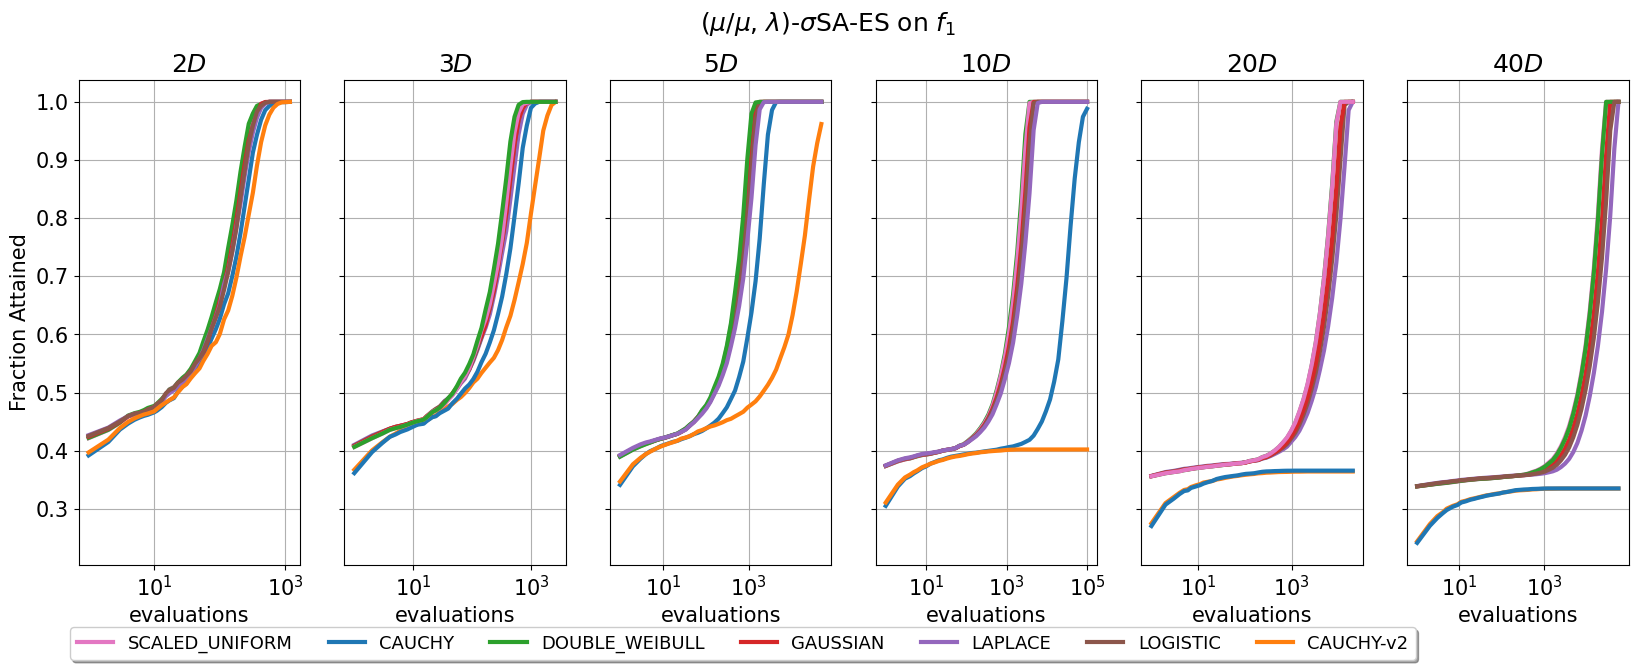

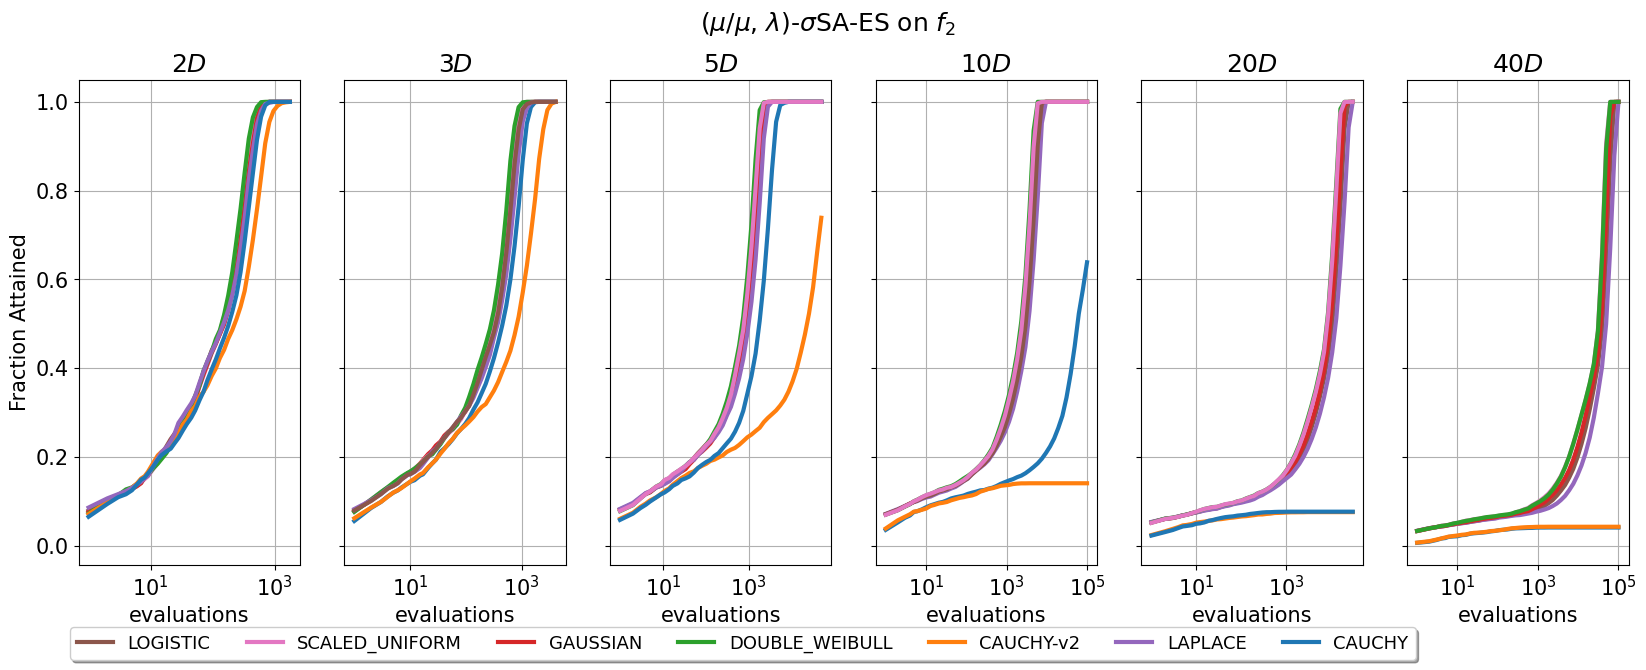

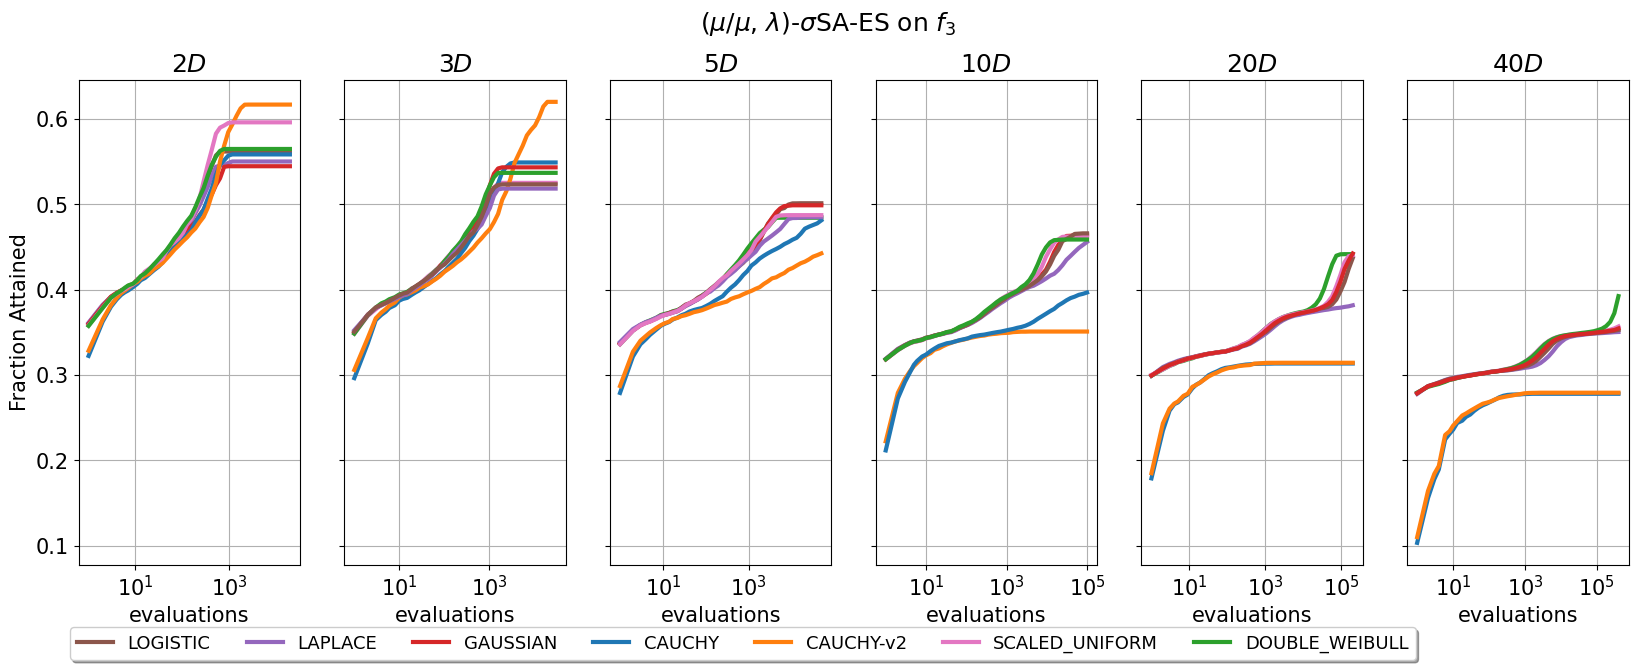

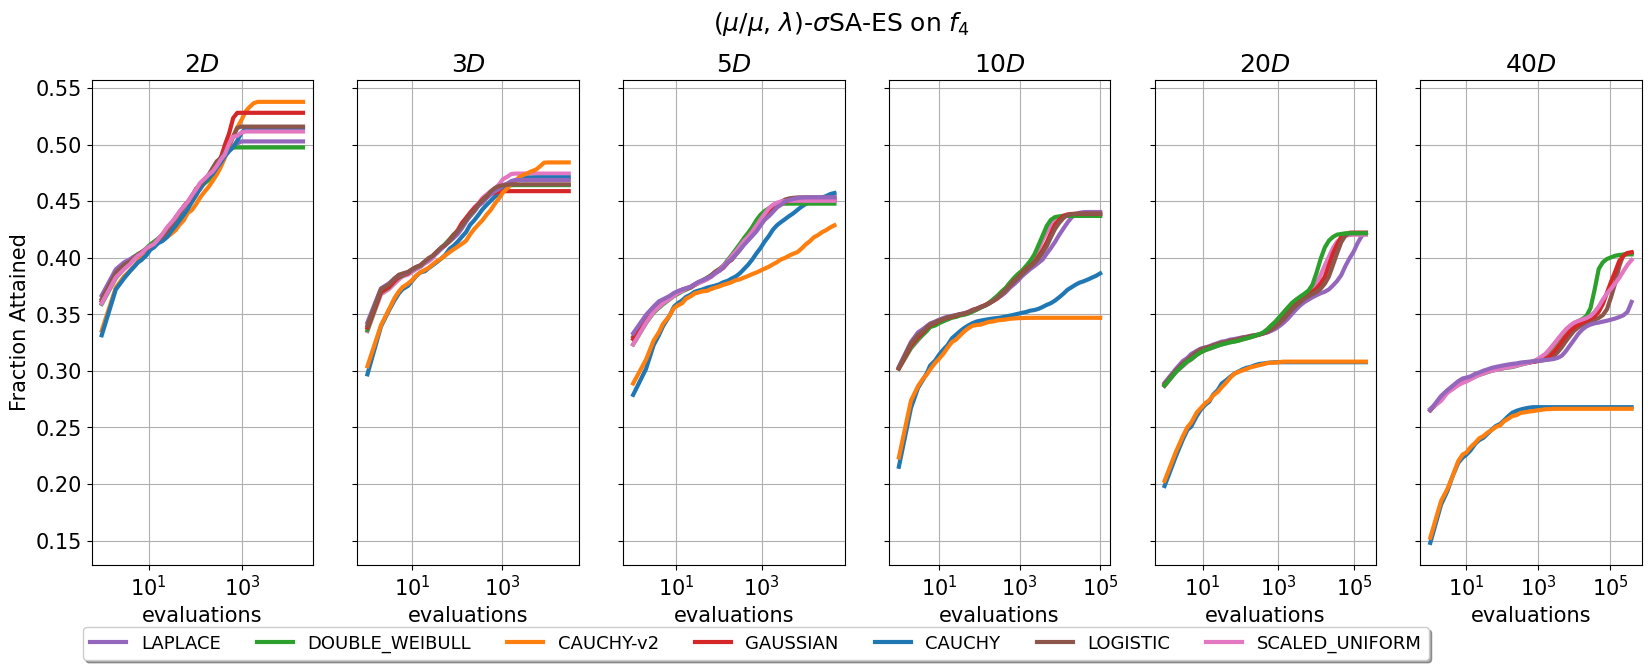

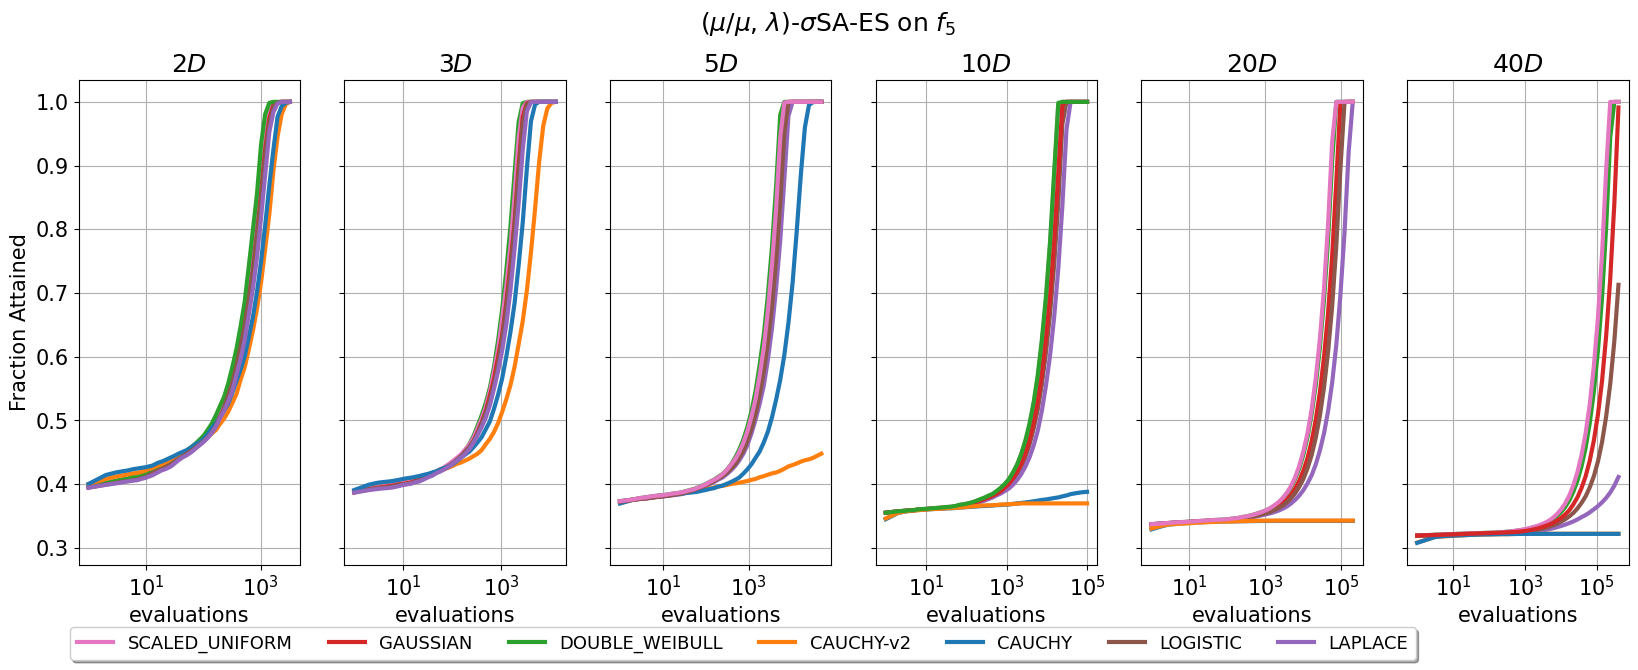

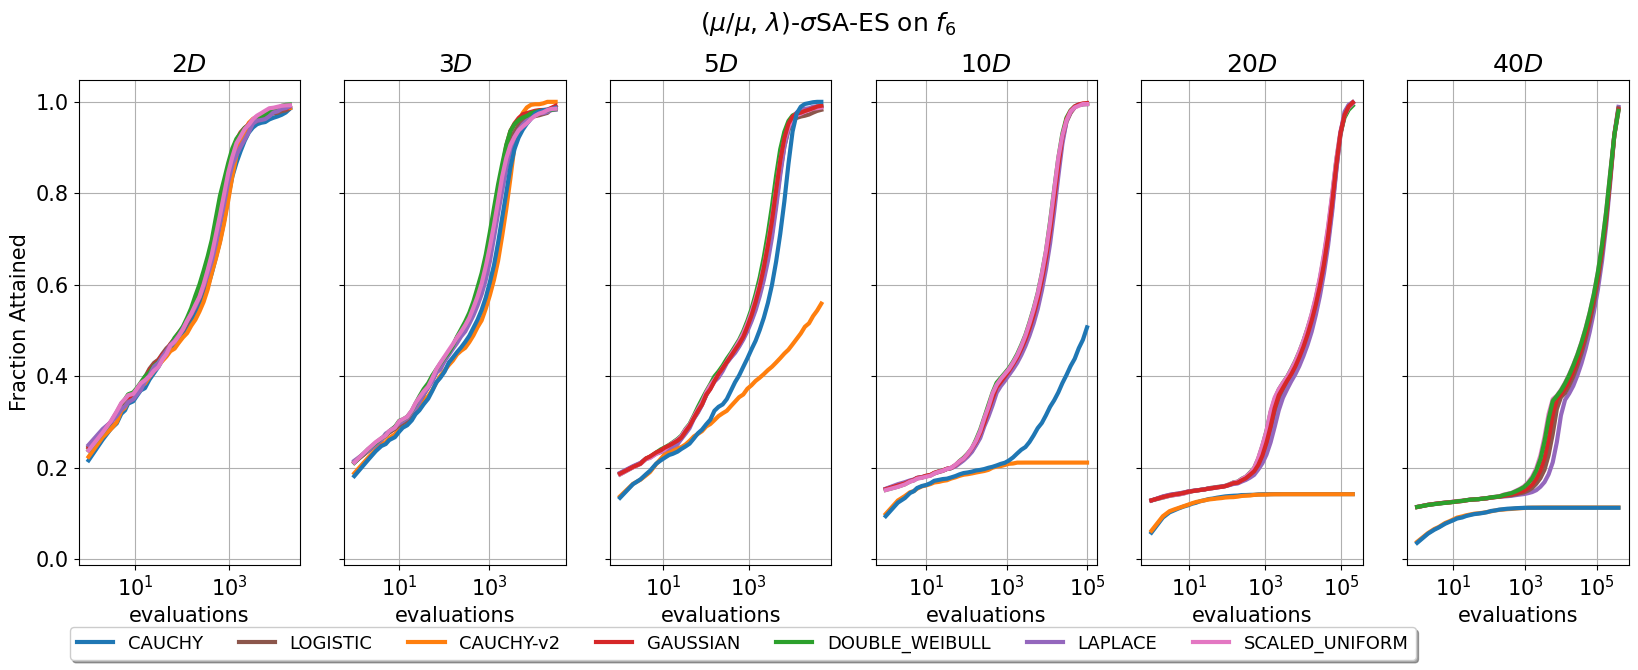

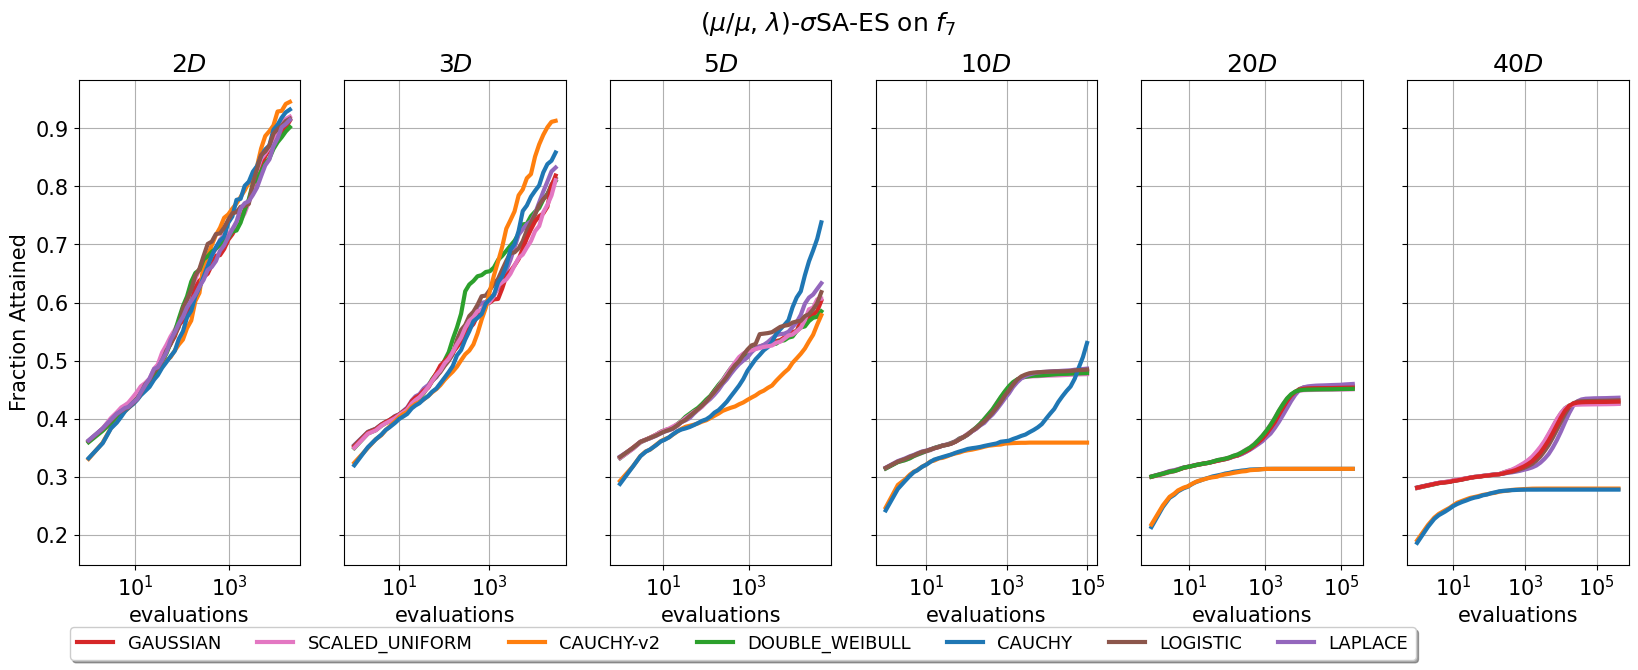

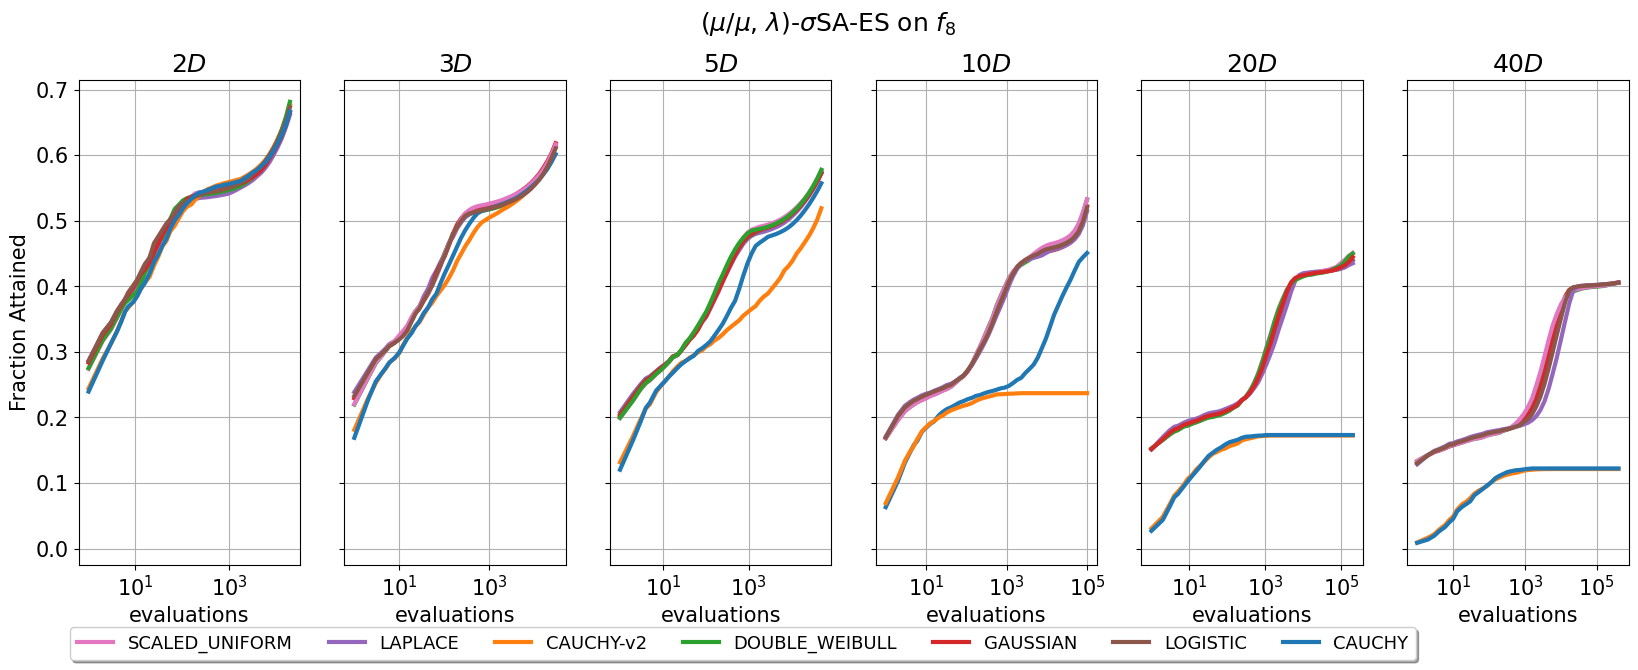

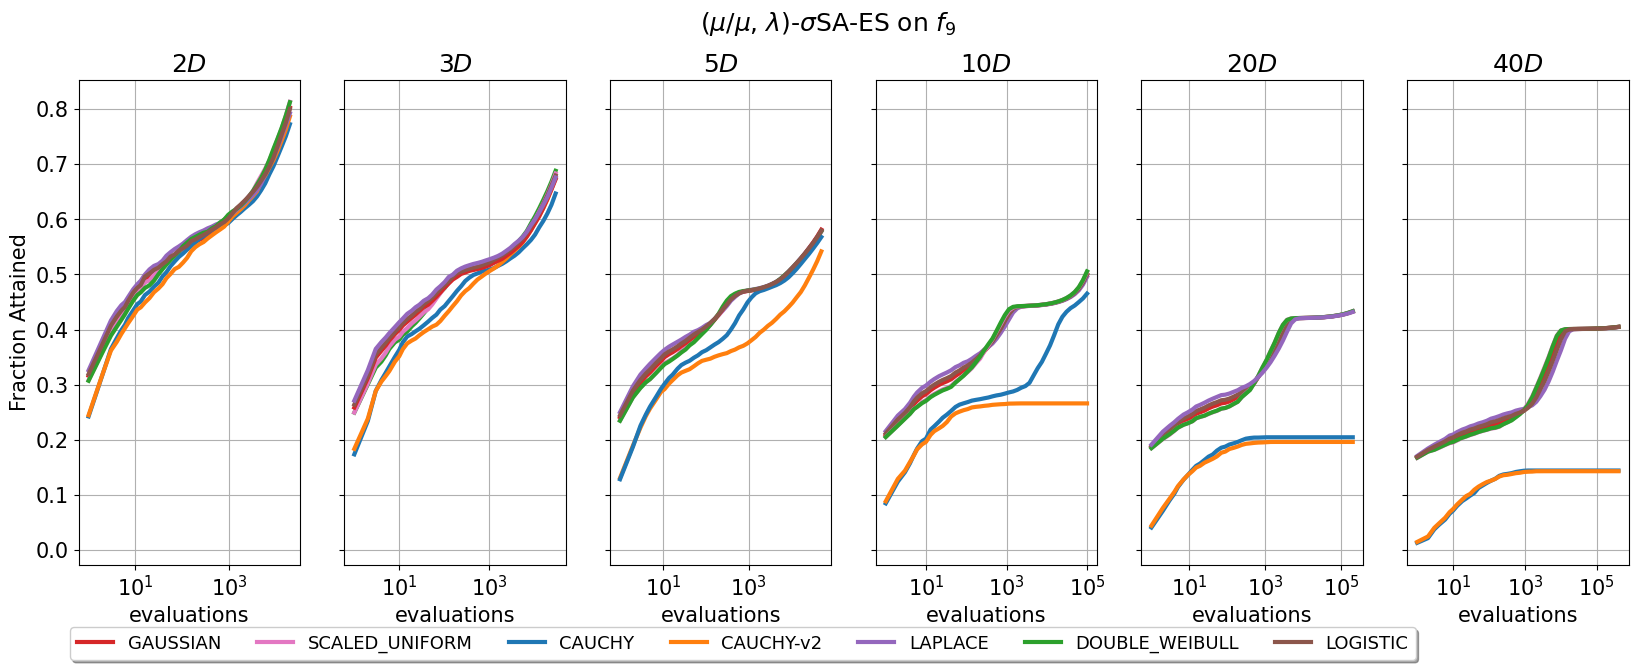

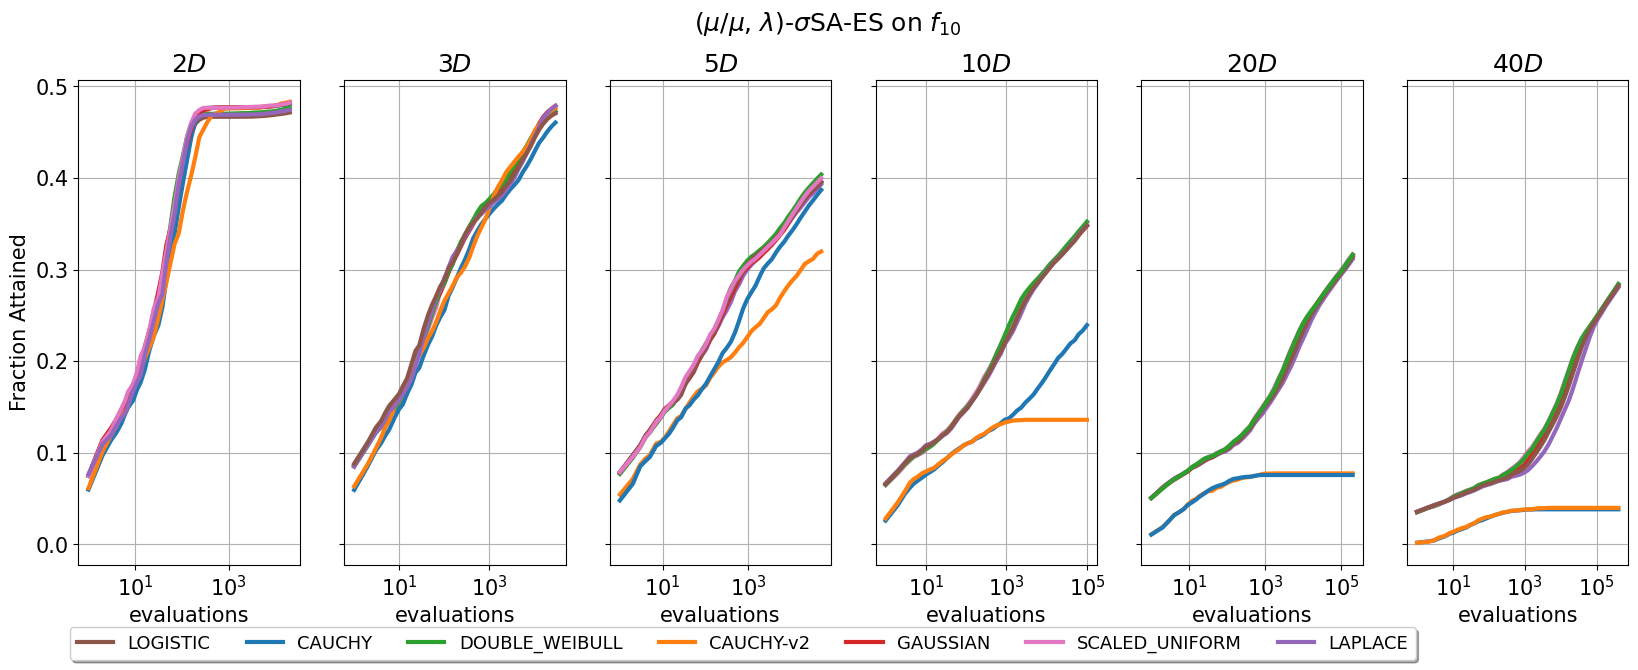

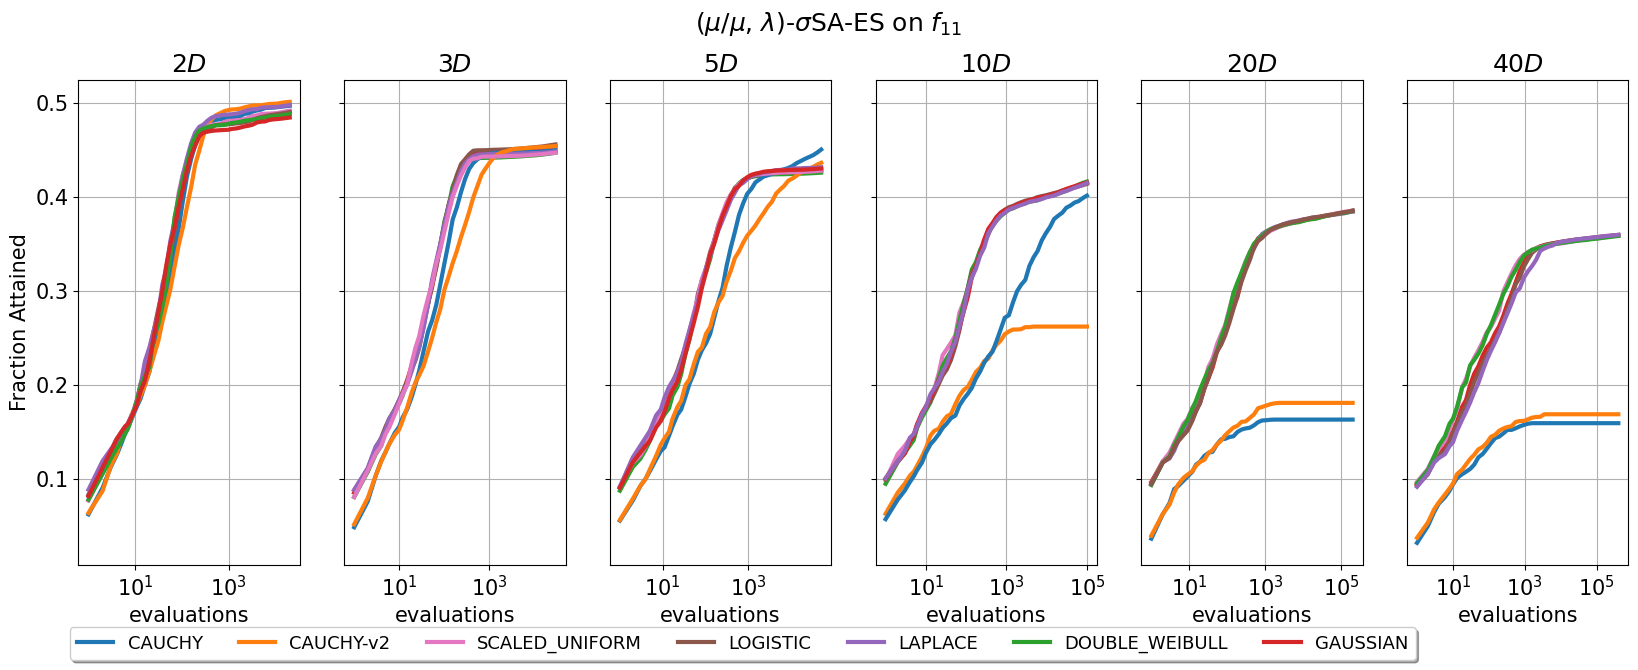

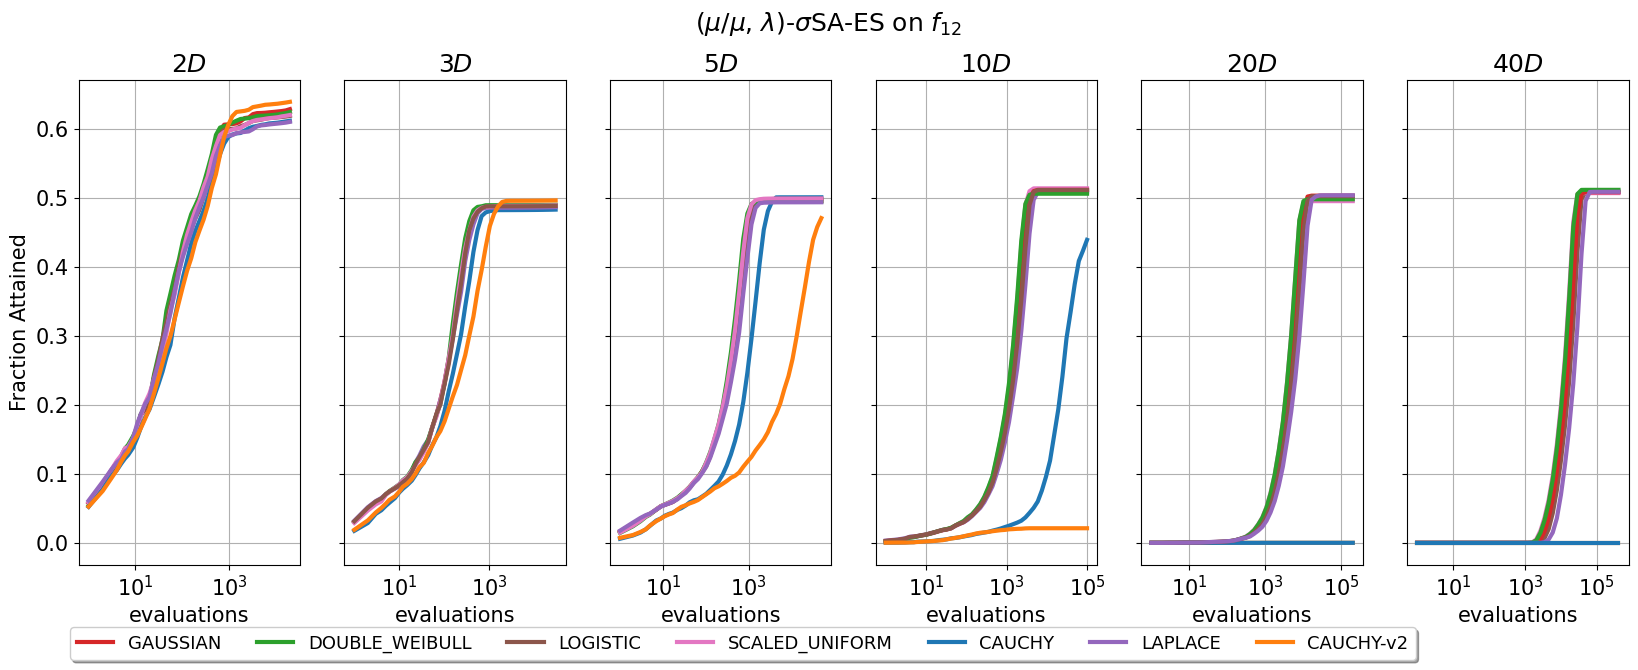

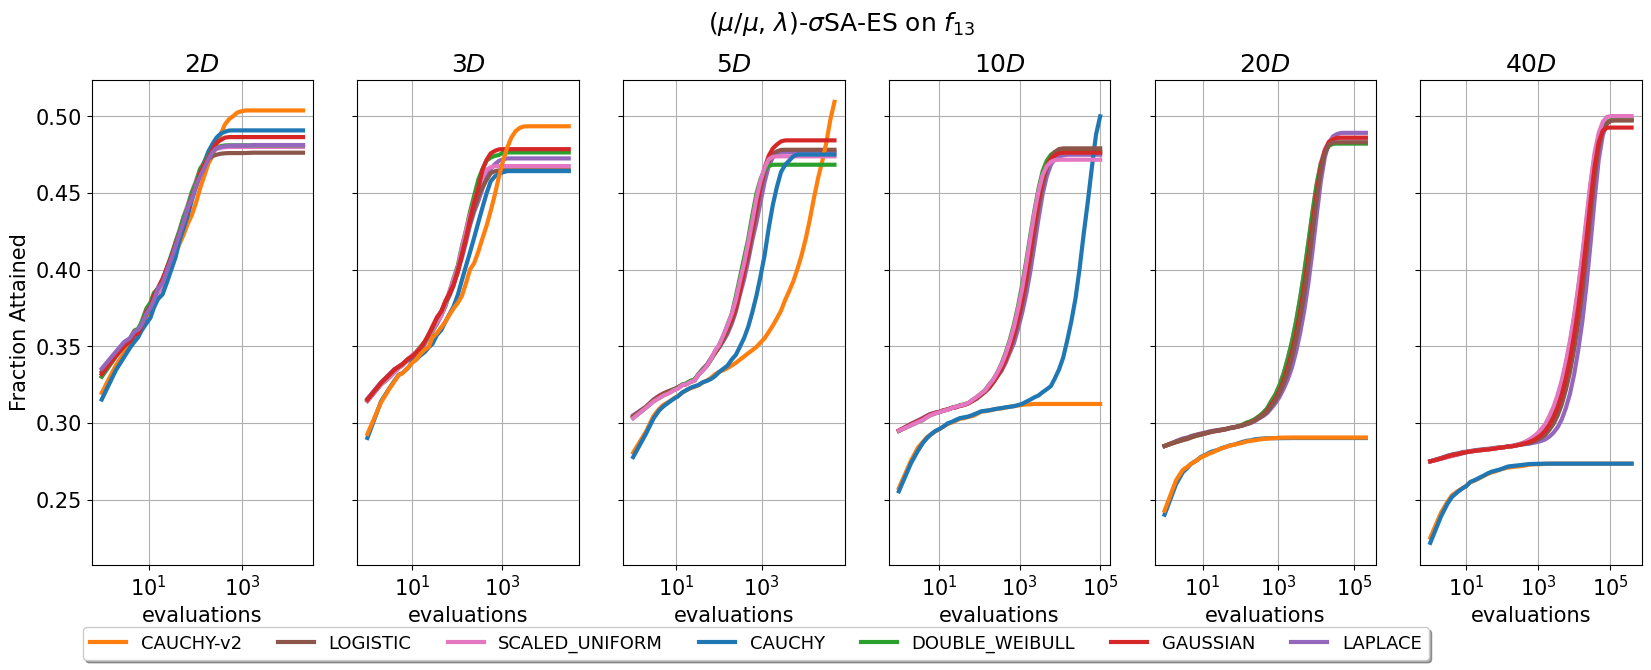

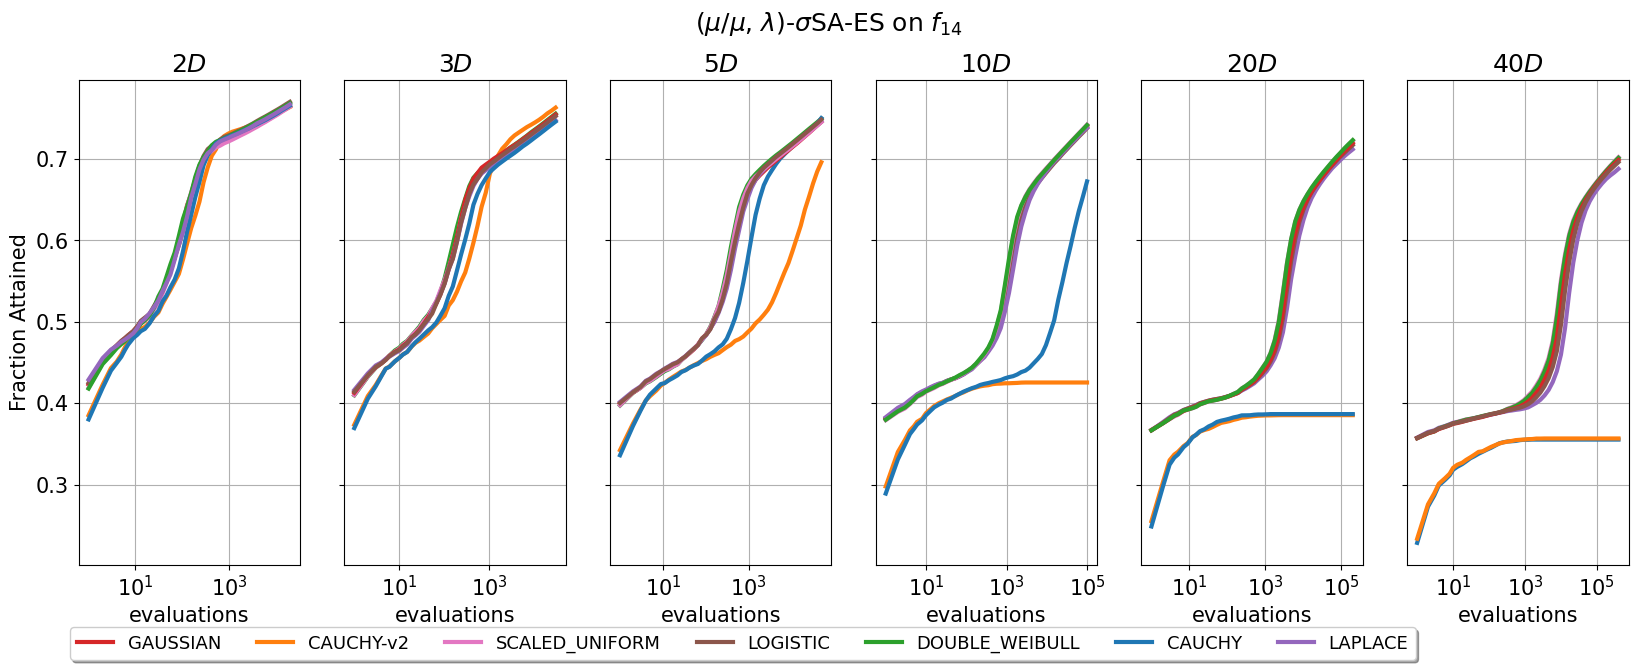

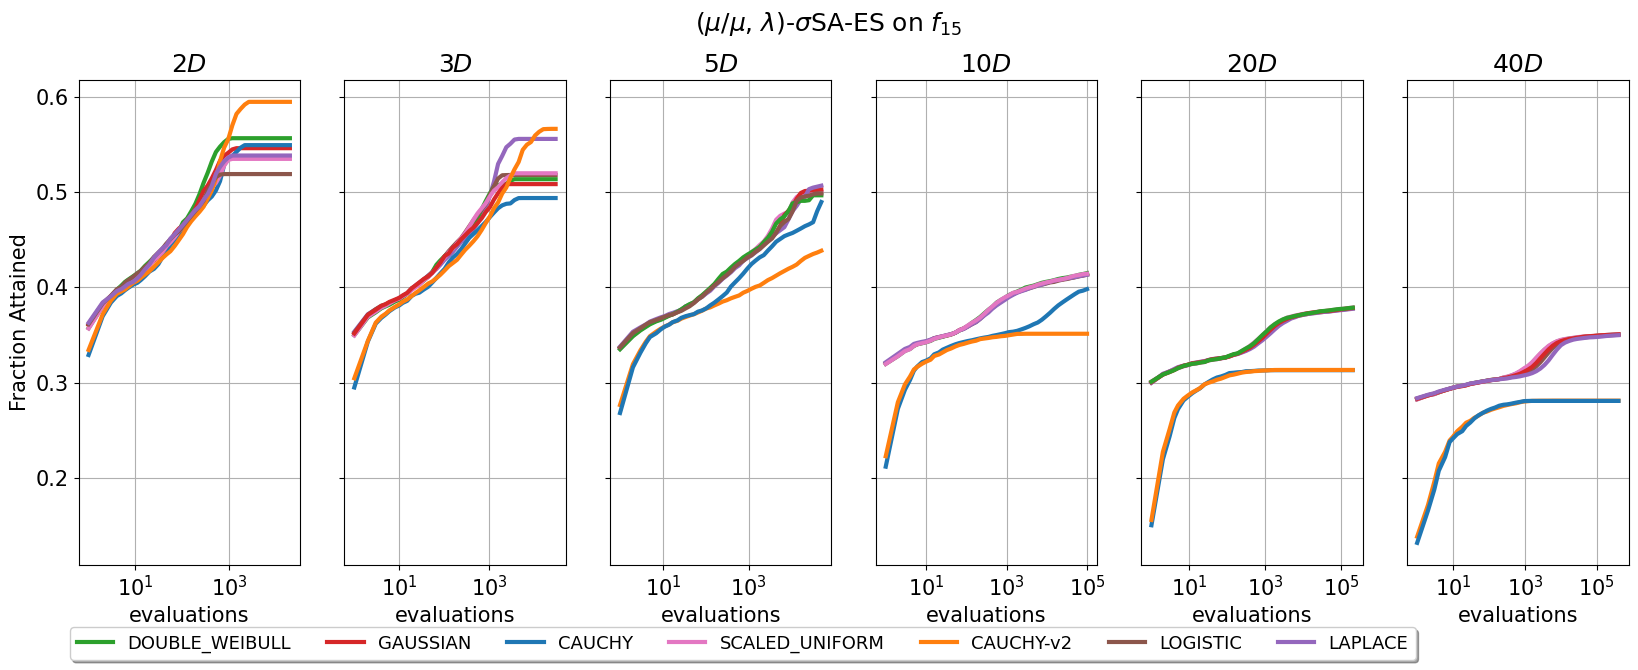

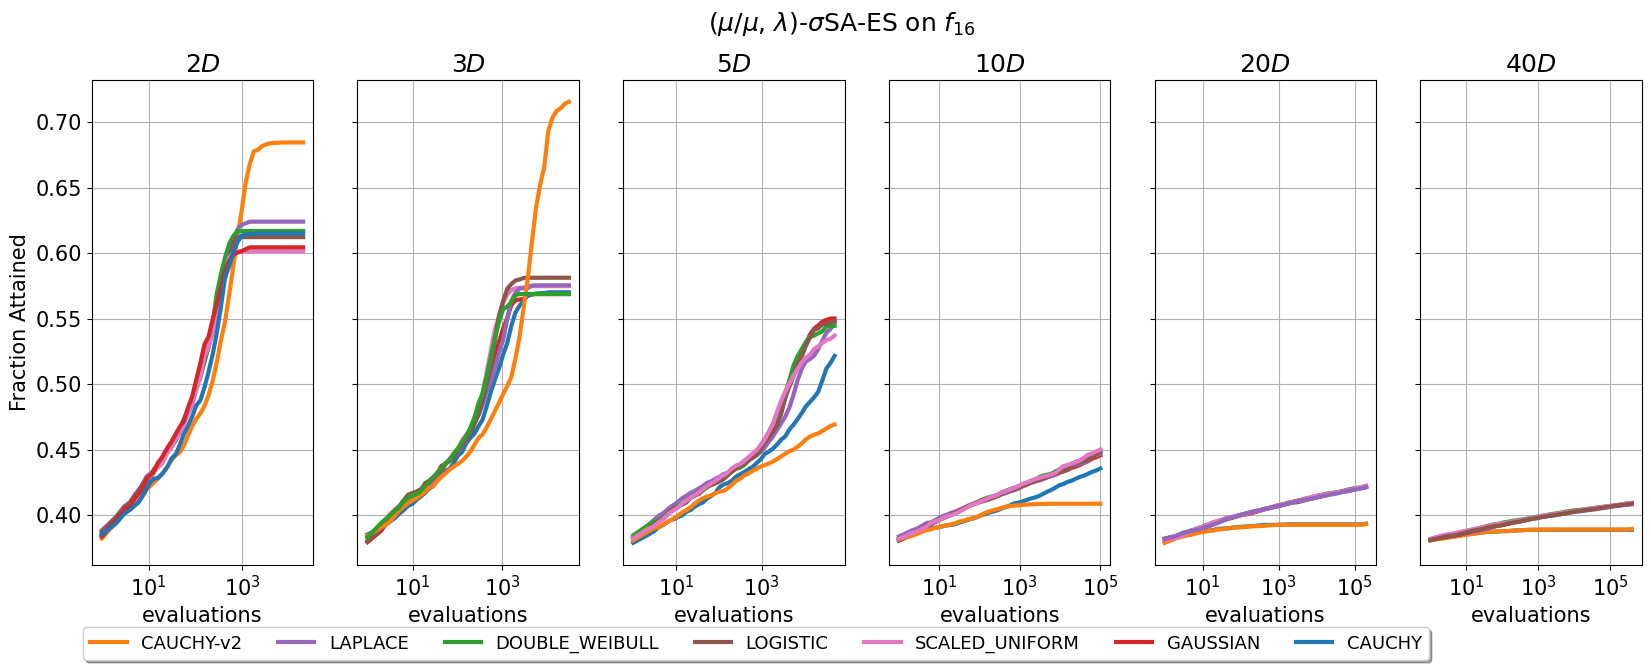

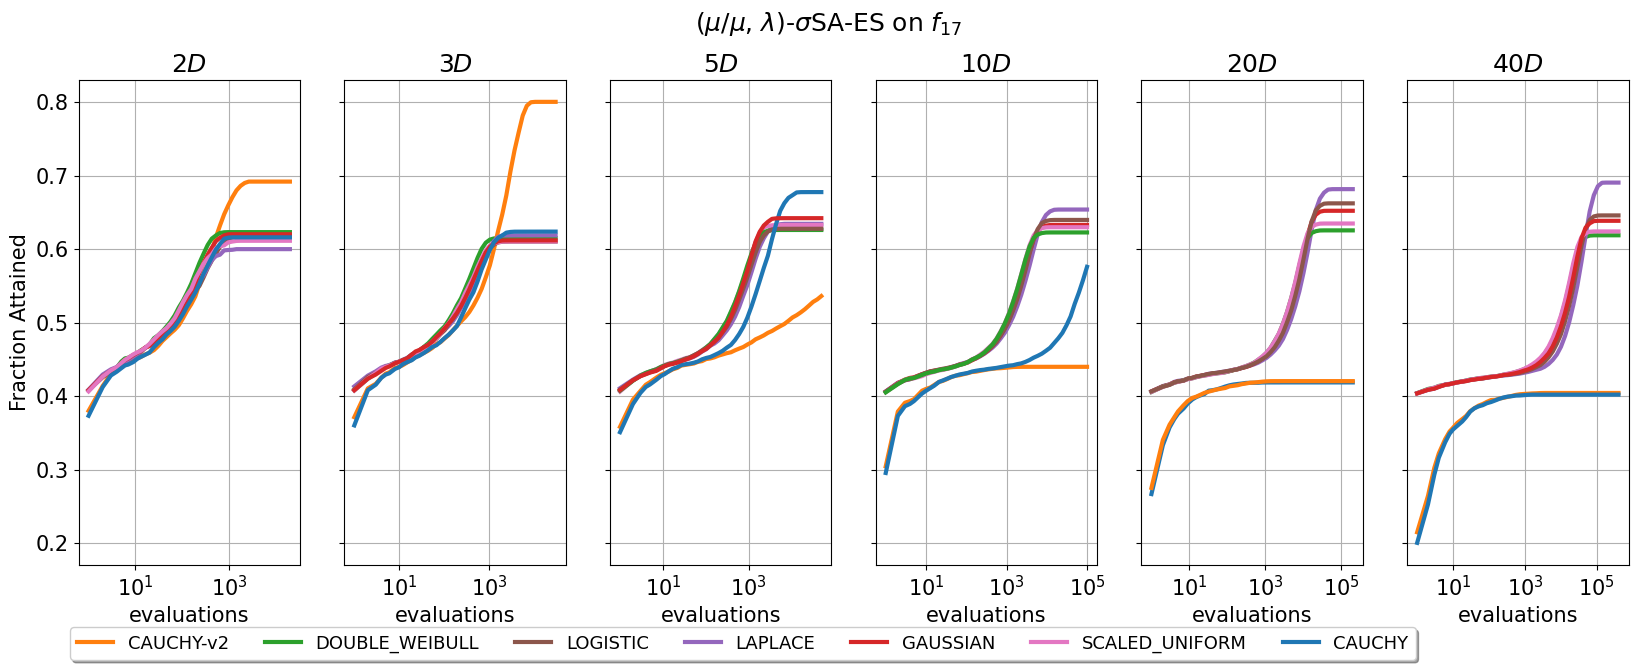

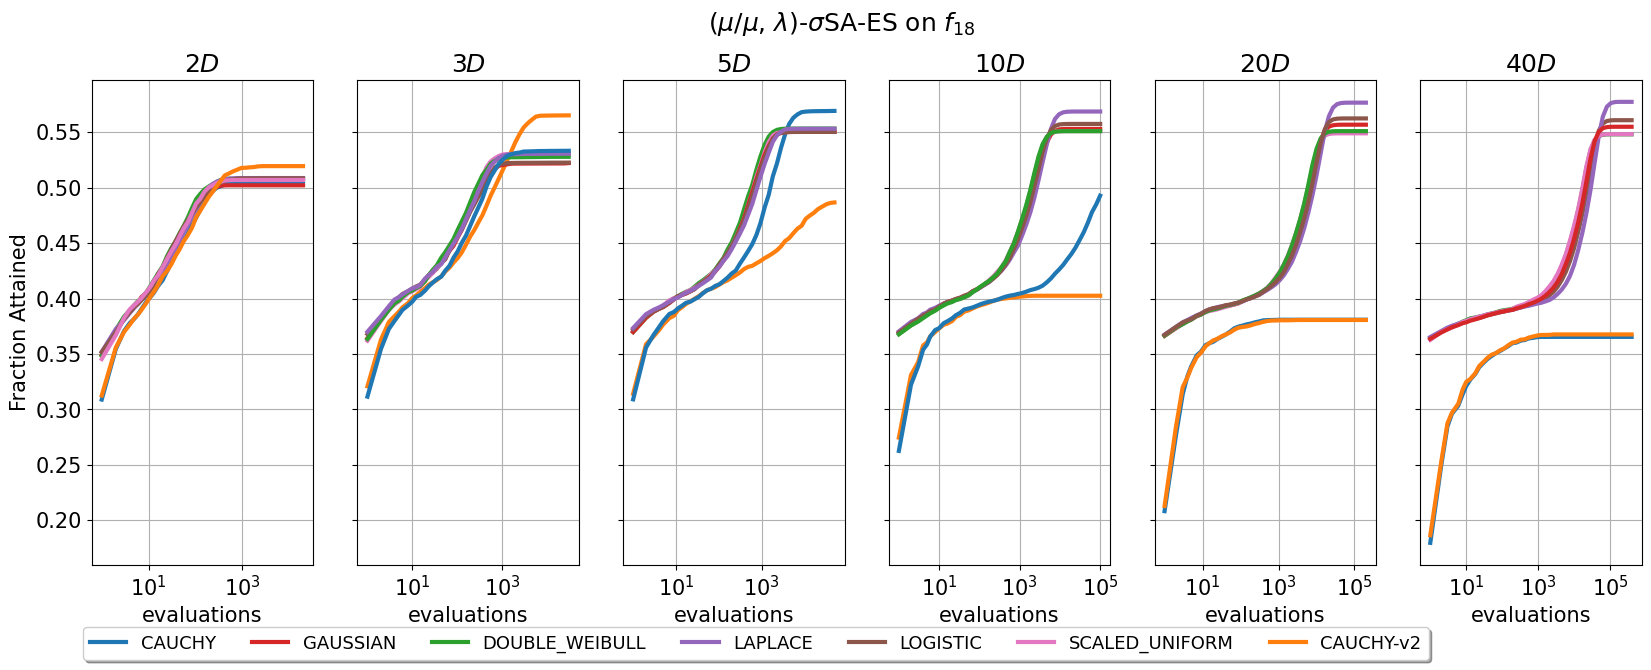

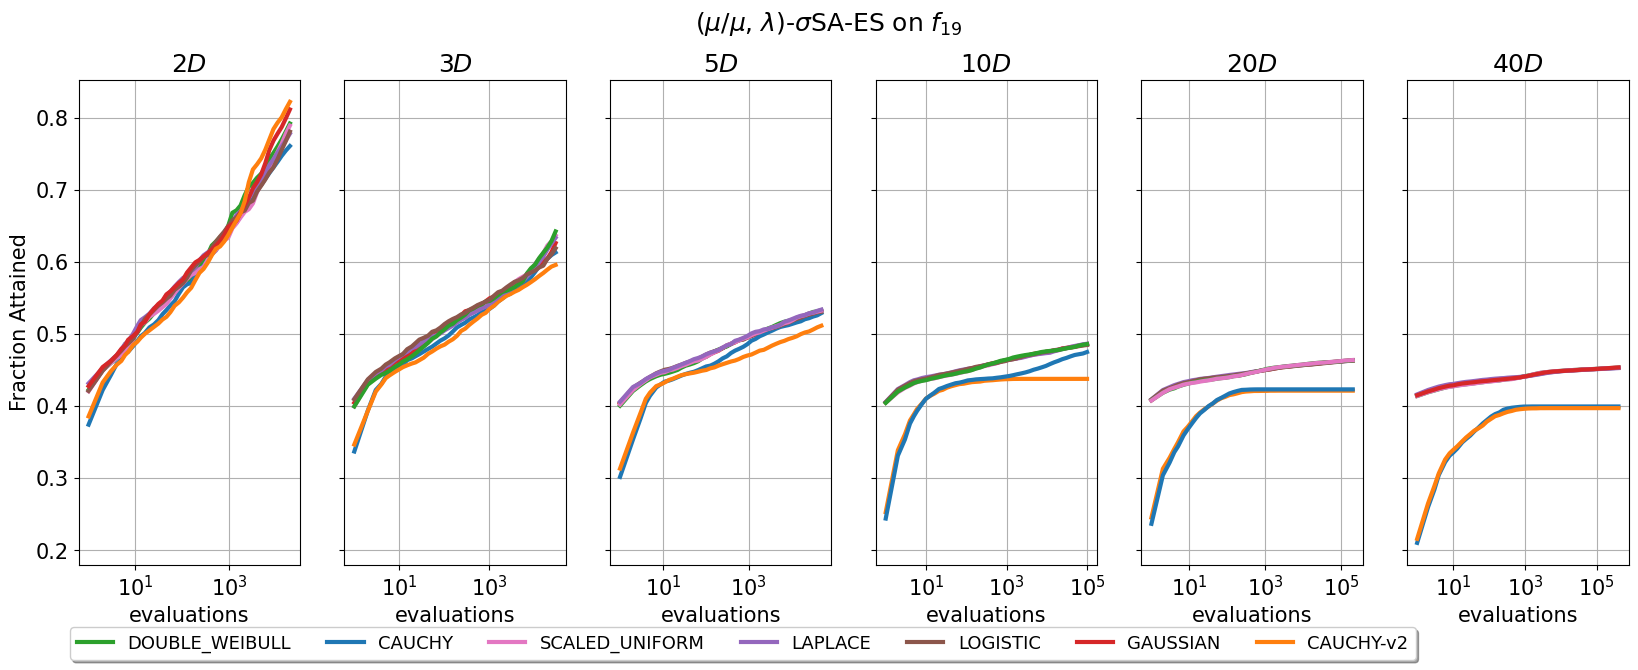

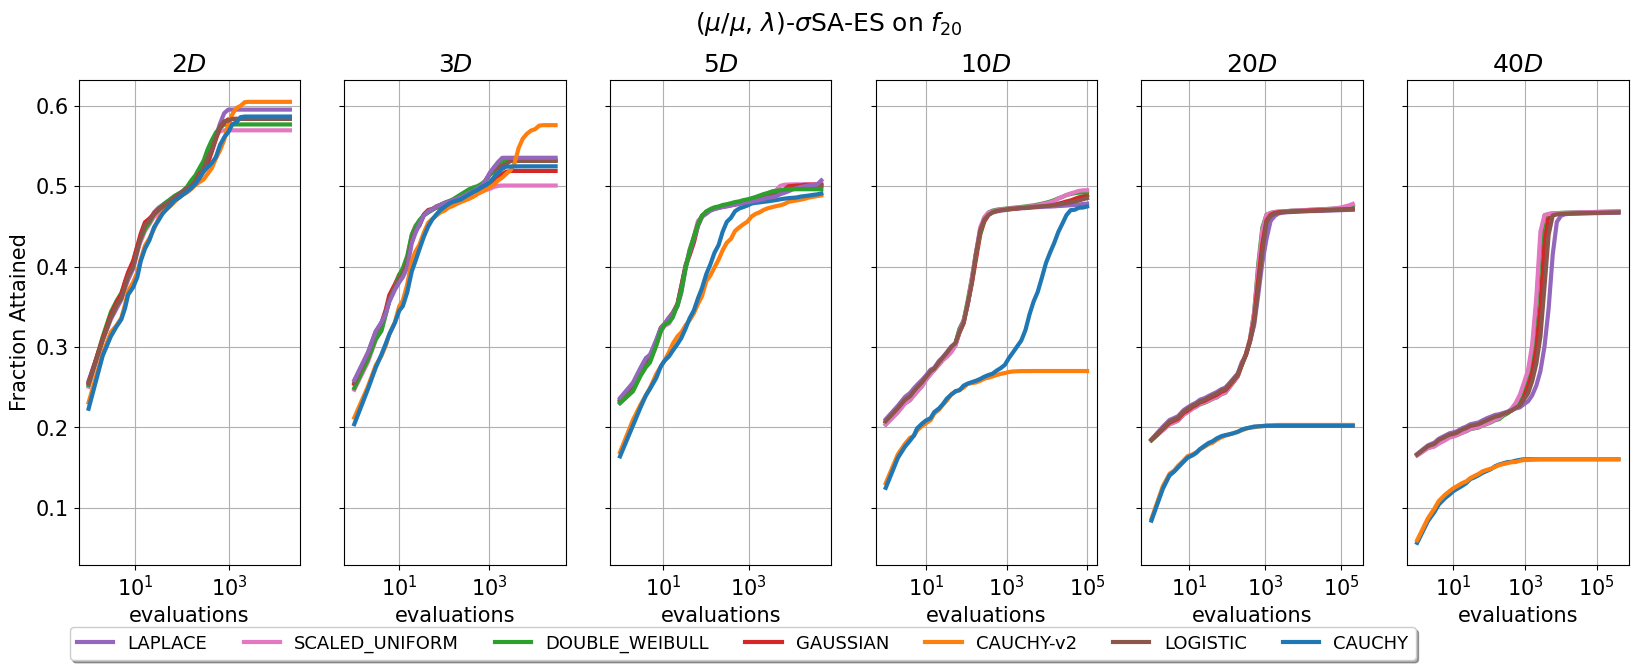

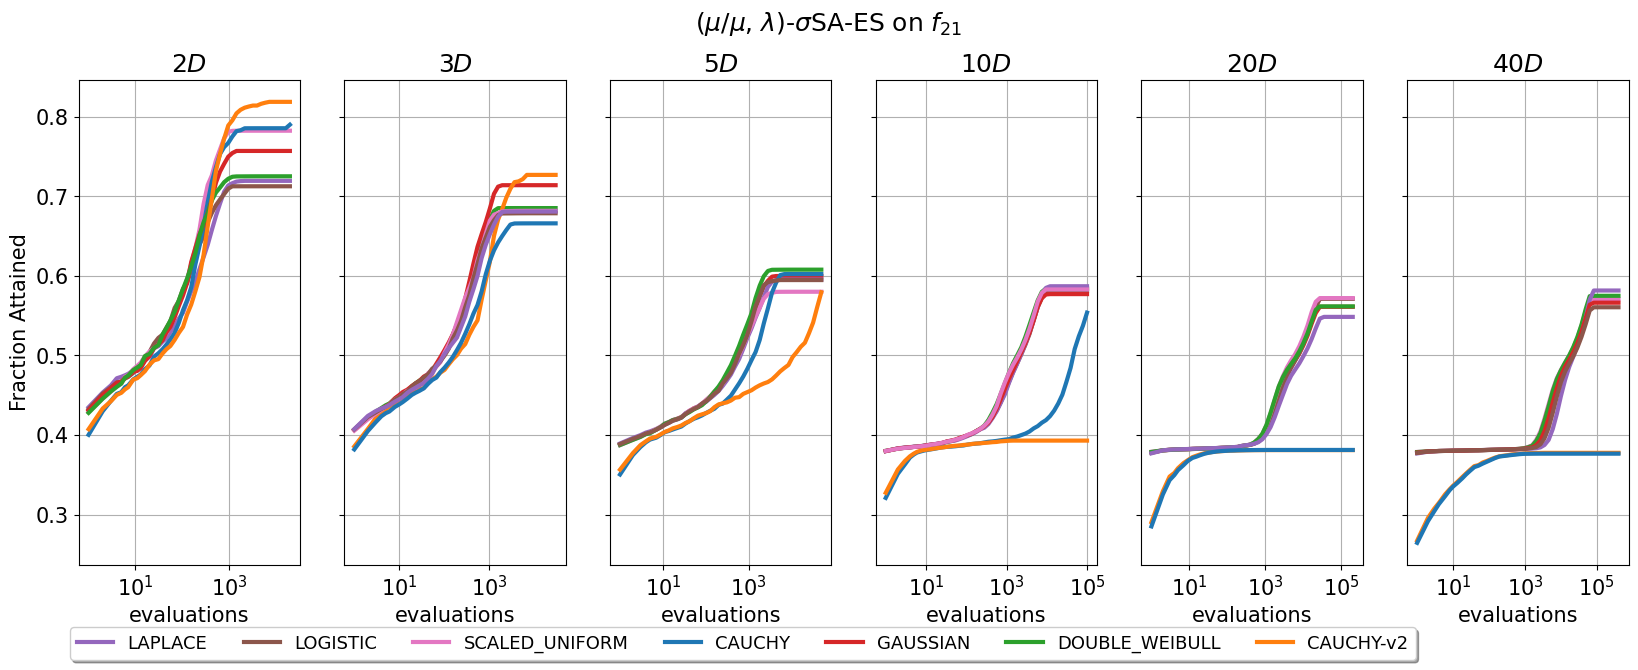

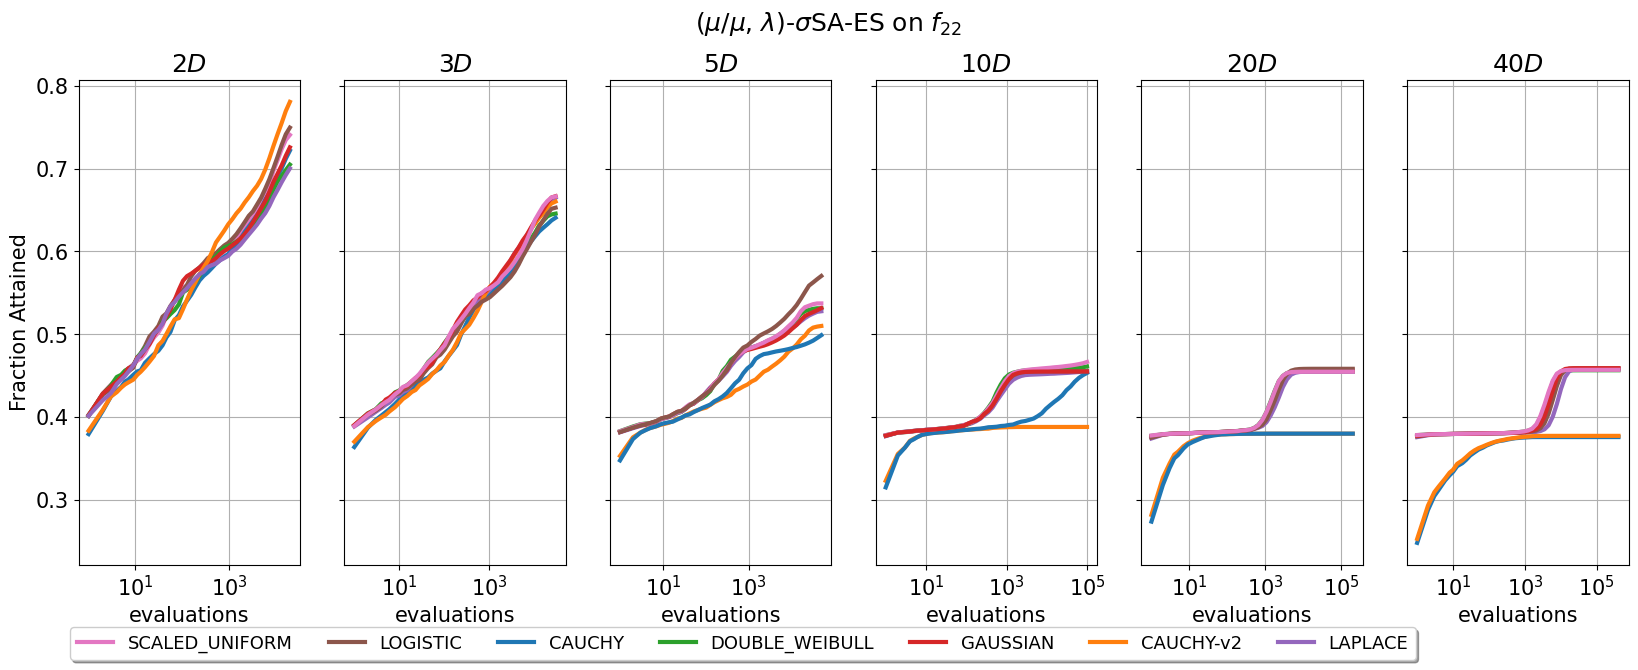

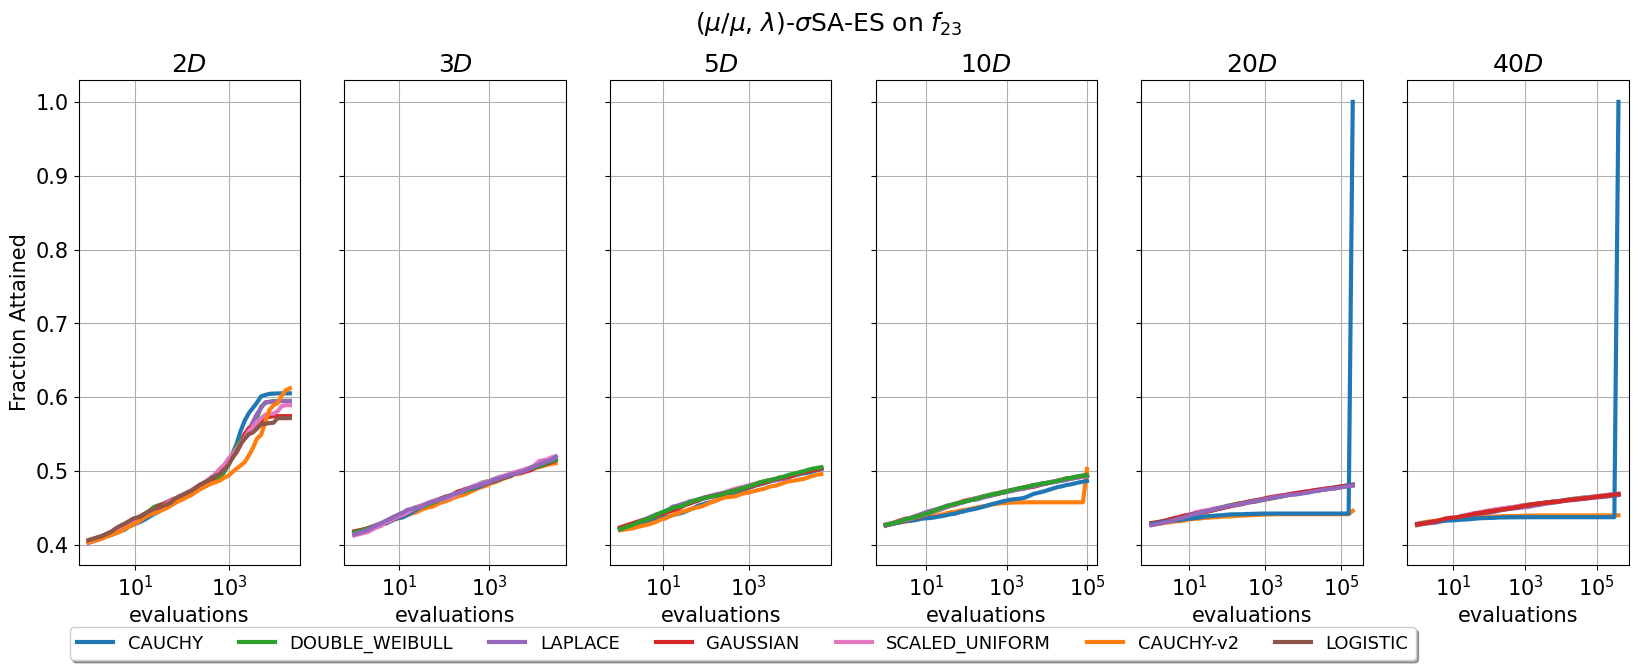

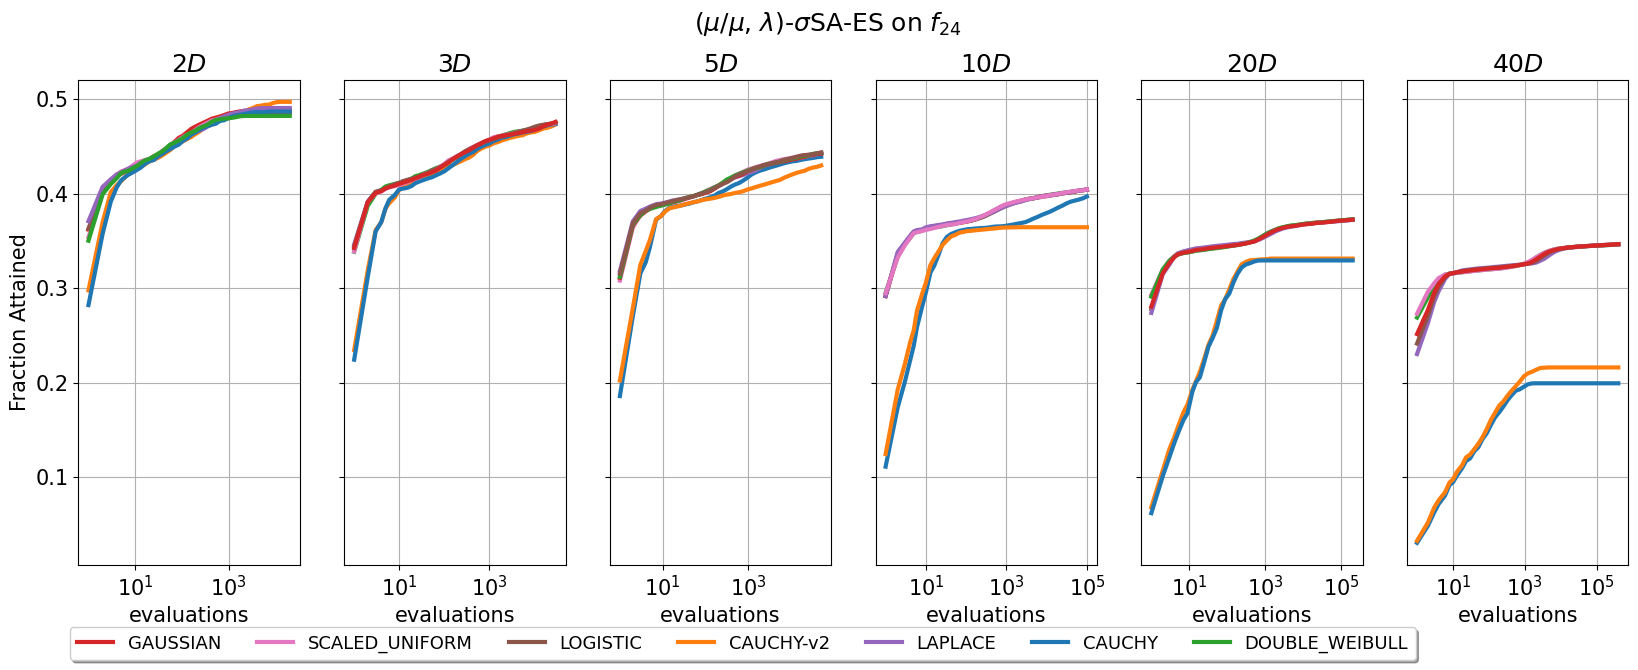

In [72]:
# make_ecdfs(one_plus_one, "(1+1)-ES", "1p1", 22)
make_ecdfs(mu_comma, "($\mu/\mu$, $\lambda$)-$\sigma$SA-ES", "mu_comma", 22)
# make_ecdfs(cma_es, "CMA-ES", "cma_es", 15)
# make_ecdfs(cma_es_sob, "CMA-ES (Sobol)", "cma_es_sob", 13, groupby_word="GAUSSIAN", legend_nrow=2)
# make_ecdfs(ecma_es, "eCMA-ES", "ecma_es", 16)

# make_ecdfs(reecma_es, "eCMA-ES (Restart)", "re_ecma_es", 18)

In [2]:
x_values = ins.get_sequence(1, 40 * 10_000, 50, scale_log=True, cast_to_int=True)
manager, algs = get_manager(cma_es_sob)
df = manager.load(True, False, include_columns=["algorithm_name", "function_id", "dimension"], x_values=x_values)

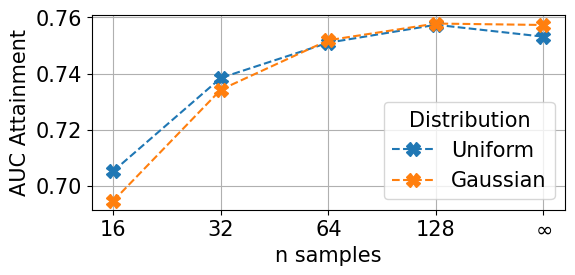

In [8]:
aocc = []
for name, data in df.group_by("algorithm_name"):
    dist = name[0].split("-")[3].split("_")[-1]
    try:
        cache_size = int(name[0].split("-")[-1])
    except:
        cache_size = '$\infty$'
    line = ins.transform_fval(data).group_by("evaluations").agg(pl.col("eaf").mean()).sort("evaluations")
    aocc.append((calc_aocc(line), dist, cache_size))

aocc = pl.DataFrame(aocc, schema=["aocc", "dist", "cache_size"], orient='row')

ids = ["16", "32", "64", "128", '$\infty$']
plt.figure(figsize=(6, 3))
for dist in aocc['dist'].unique():
    dd = aocc.filter(aocc['dist'] == dist)
    idx = np.argsort(np.array([ids.index(x) for x in dd['cache_size']]))
    plt.plot(dd['cache_size'].to_numpy()[idx], dd['aocc'].to_numpy()[idx], label=dist.title(), marker='X', markersize=10, linestyle='dashed')
    
plt.ylabel("AUC Attainment")
plt.grid()
plt.xlabel("n samples")
plt.legend(title='Distribution')
plt.tight_layout()
plt.savefig("figures/auc_sobol.pdf")

In [389]:
d = 40
4 + np.floor(3 * np.log(d))

15.0

In [92]:
x_values = ins.get_sequence(1, 40 * 10_000, 50, scale_log=True, cast_to_int=True)

manager = ins.DataManager()
for ds in (one_plus_one, mu_comma, cma_es, ecma_es):
    m, algs = get_manager(ds)
    manager += m

df = manager.load(True, False, include_columns=["algorithm_name", "function_id", "dimension"], x_values=x_values)

df = df.filter(
    df['algorithm_name'] != "eCMA-ES-UNIFORM-CAUCHY",
    df['algorithm_name'] != "CMA-ES-UNIFORM-CAUCHY",
)

df = df.with_columns(
    pl.col("algorithm_name").str.replace("-v2", "")
)

In [145]:
x_values

array([     1,      2,      3,      4,      6,      8,     10,     13,
           18,     23,     30,     39,     51,     67,     87,    114,
          148,    193,    251,    327,    426,    554,    721,    938,
         1221,   1589,   2067,   2690,   3500,   4554,   5926,   7711,
        10033,  13055,  16987,  22103,  28759,  37420,  48689,  63352,
        82431, 107255, 139556, 181583, 236267, 307420, 400000])

In [93]:
algs = []
for ds in (one_plus_one, mu_comma, cma_es, ecma_es):
    m, ags = get_manager(ds)
    algs.extend(ags)
algs, samplers = list(map(sorted, map(list, map(set, zip(*[x.split("-UNIFORM-") for x in algs])))))
samplers.remove("CAUCHY-v2")

samplers,algs

(['CAUCHY',
  'DOUBLE_WEIBULL',
  'GAUSSIAN',
  'LAPLACE',
  'LOGISTIC',
  'SCALED_UNIFORM'],
 ['CMA-ES', 'MuCommaLambda', 'OnePlusOne', 'eCMA-ES'])

In [94]:
nice_alg_names = {
    'OnePlusOne': '(1+1)-ES', 
    'MuCommaLambda': '($\mu/\mu$, $\lambda$)-$\sigma$SA-ES', 
    'CMA-ES': '($\mu/\mu_W$, $\lambda$)-CMA-ES', 
    'eCMA-ES': '($\mu/\mu_W$ + $\lambda$)-CMA-ES',
}

shape: (6,)
Series: 'dimension' [u16]
[
	2
	3
	5
	10
	20
	40
]

In [119]:

colors = dict(zip(samplers, mcolors.TABLEAU_COLORS))
markers = dict(zip(algs, "1234"))

linestyle = 'solid'
linewidth = 2
markersize= 15
markeredgewidth = 2

from matplotlib.lines import Line2D


function_groups = (
    (1,2,3, 4, 5),
    (6, 7, 8, 9),
    (10, 11, 12, 13, 14),
    (15, 16, 17, 18, 19),
    (20, 21, 22, 23, 24)
)
aoccs = []
for d in df['dimension'].unique():
    for gi, functions in enumerate(function_groups, 1):
        # if gi != 2: continue
        # f, (ax, ax2) = plt.subplots(1, 2, figsize=(16, 6),  gridspec_kw={'width_ratios': [3, 1]})
        aocc = []
        
        for name, data in df.group_by("algorithm_name"):
            data = data.filter(data['function_id'].is_in(functions), data['dimension']==d)
            line = ins.transform_fval(data).group_by("evaluations").agg(pl.col("eaf").mean()).sort("evaluations")
            
            
            alg, sampler = name[0].split("-UNIFORM-")
            # if alg not  in ("OnePlusOne", "MuCommaLambda"): continue
            
            aocc.append((gi, d, calc_aocc(line), alg, sampler))
            # ax.semilogx(line['evaluations'], line['eaf'], c=colors[sampler], linestyle=linestyle, alpha=.5, linewidth=linewidth)
            # ax.semilogx(line['evaluations'], line['eaf'], c=colors[sampler], marker=markers[alg], linestyle='', alpha=1, markersize=markersize, markeredgewidth=markeredgewidth)

        aocc = pl.DataFrame(aocc, schema=["gi", "d", "aocc", "alg", "sampler"], orient='row')
        aoccs.append(aocc)
    continue
    
    handles = [Line2D([0], [0], linestyle='')]
    labels = ["$\\bf{Sampler}$"]
    for sampler, col in colors.items():
        handles.append(Line2D([0], [0], label=sampler, color=col, linestyle=linestyle, linewidth=linewidth)) 
        labels.append(sampler.title().replace("Scaled_", "").replace("Double_", "d"))


    handles.append(Line2D([0], [0], linestyle=''))
    labels.append("$\\bf{Algorithm}$")    


    for alg, name in nice_alg_names.items():
        handles.append(Line2D([0], [0], label=alg, color='black', marker=markers[alg], linestyle=linestyle, linewidth=linewidth, markersize=markersize, markeredgewidth=markeredgewidth))
        labels.append(name)
        
    handles.append(Line2D([0], [0], linestyle=''))
    labels.append("")      
        
    ax.legend(handles, labels, loc='upper left', fancybox=True, shadow=True, fontsize=14, ncol=2)
    ax.set_ylabel("Fraction Attained")
    ax.set_xlabel("Evaluations")
    ax.grid(which="both", axis="both")


    for alg, name in nice_alg_names.items():
        group = aocc.filter(aocc['alg'] == alg)
        idx = np.argsort(group['sampler'])
        x_values = np.array([samplers.index(g) for g in group['sampler'][idx]])
        p = ax2.plot(x_values, group['aocc'][idx], label=name, linestyle='dashed', marker='o')
        ax2.plot(x_values, group['aocc'][idx], marker=markers[alg], linestyle='dashed',  color=p[0].get_color(), alpha=.5)
        
    ax2.legend(fontsize=14)
    ax2.set_ylabel("AUC Attainment Curve")
    ax2.set_xticks(range(len(samplers)), labels=[x.title().replace("Double_", "d").replace("Scaled_", "") for x in samplers], rotation=25)
    ax2.grid()
    # ax2.set_ylim(.41, .8)

    f.suptitle(f"Group: {gi}")
    plt.tight_layout()
    plt.savefig(f"figures/overview_ecdf_group_{gi}.pdf")
# ax.set_ylim(0, 1.01);

aoccs = pl.concat(aoccs)

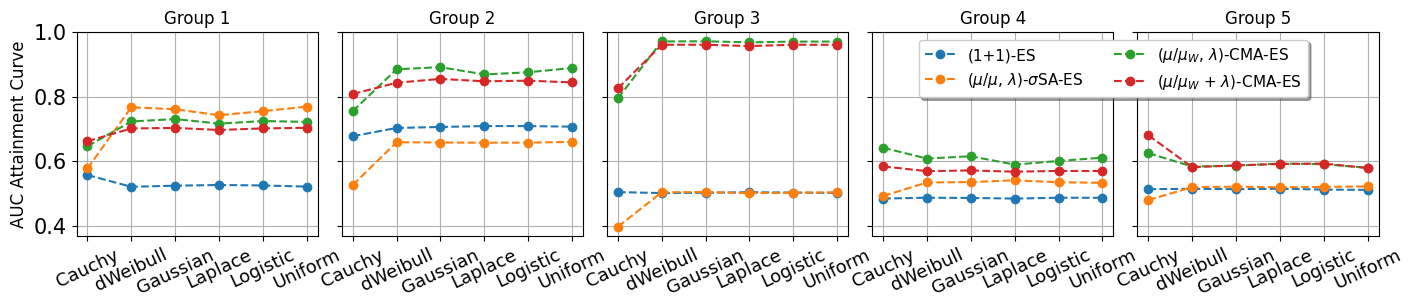

In [285]:
f, axes = plt.subplots(1, 5, figsize=(14, 3), sharey=True)
for gi, ax in enumerate(axes.ravel(), 1):
    
    for alg in nice_alg_names:
        group =  aoccs.filter(gi=gi, alg=alg)
        idx = np.argsort(group['sampler'])
        ax.plot(group['sampler'][idx], group['aocc'][idx], label=nice_alg_names[alg], marker='o', linestyle='dashed')
    
    if gi == 5: 
        h, l = ax.get_legend_handles_labels()   
        ax.legend(np.array(h), np.array(l), loc='upper center',
                fontsize=11, bbox_to_anchor=(-.1, 1), fancybox=True, shadow=True, ncol=2,
        )
    if gi == 1:
        ax.set_ylabel("AUC Attainment Curve", fontsize=12)
        
    ax.set_xticks(range(len(samplers)), labels=[x.title().replace("Double_", "d").replace("Scaled_", "") for x in samplers], rotation=25, fontsize=13)
    ax.grid()
    ax.set_title(f"Group {gi}", fontsize=12)
    
plt.subplots_adjust(wspace=0.1, bottom=.2, left=0.05, right=.98)
plt.savefig("figures/auc_per_group.pdf")


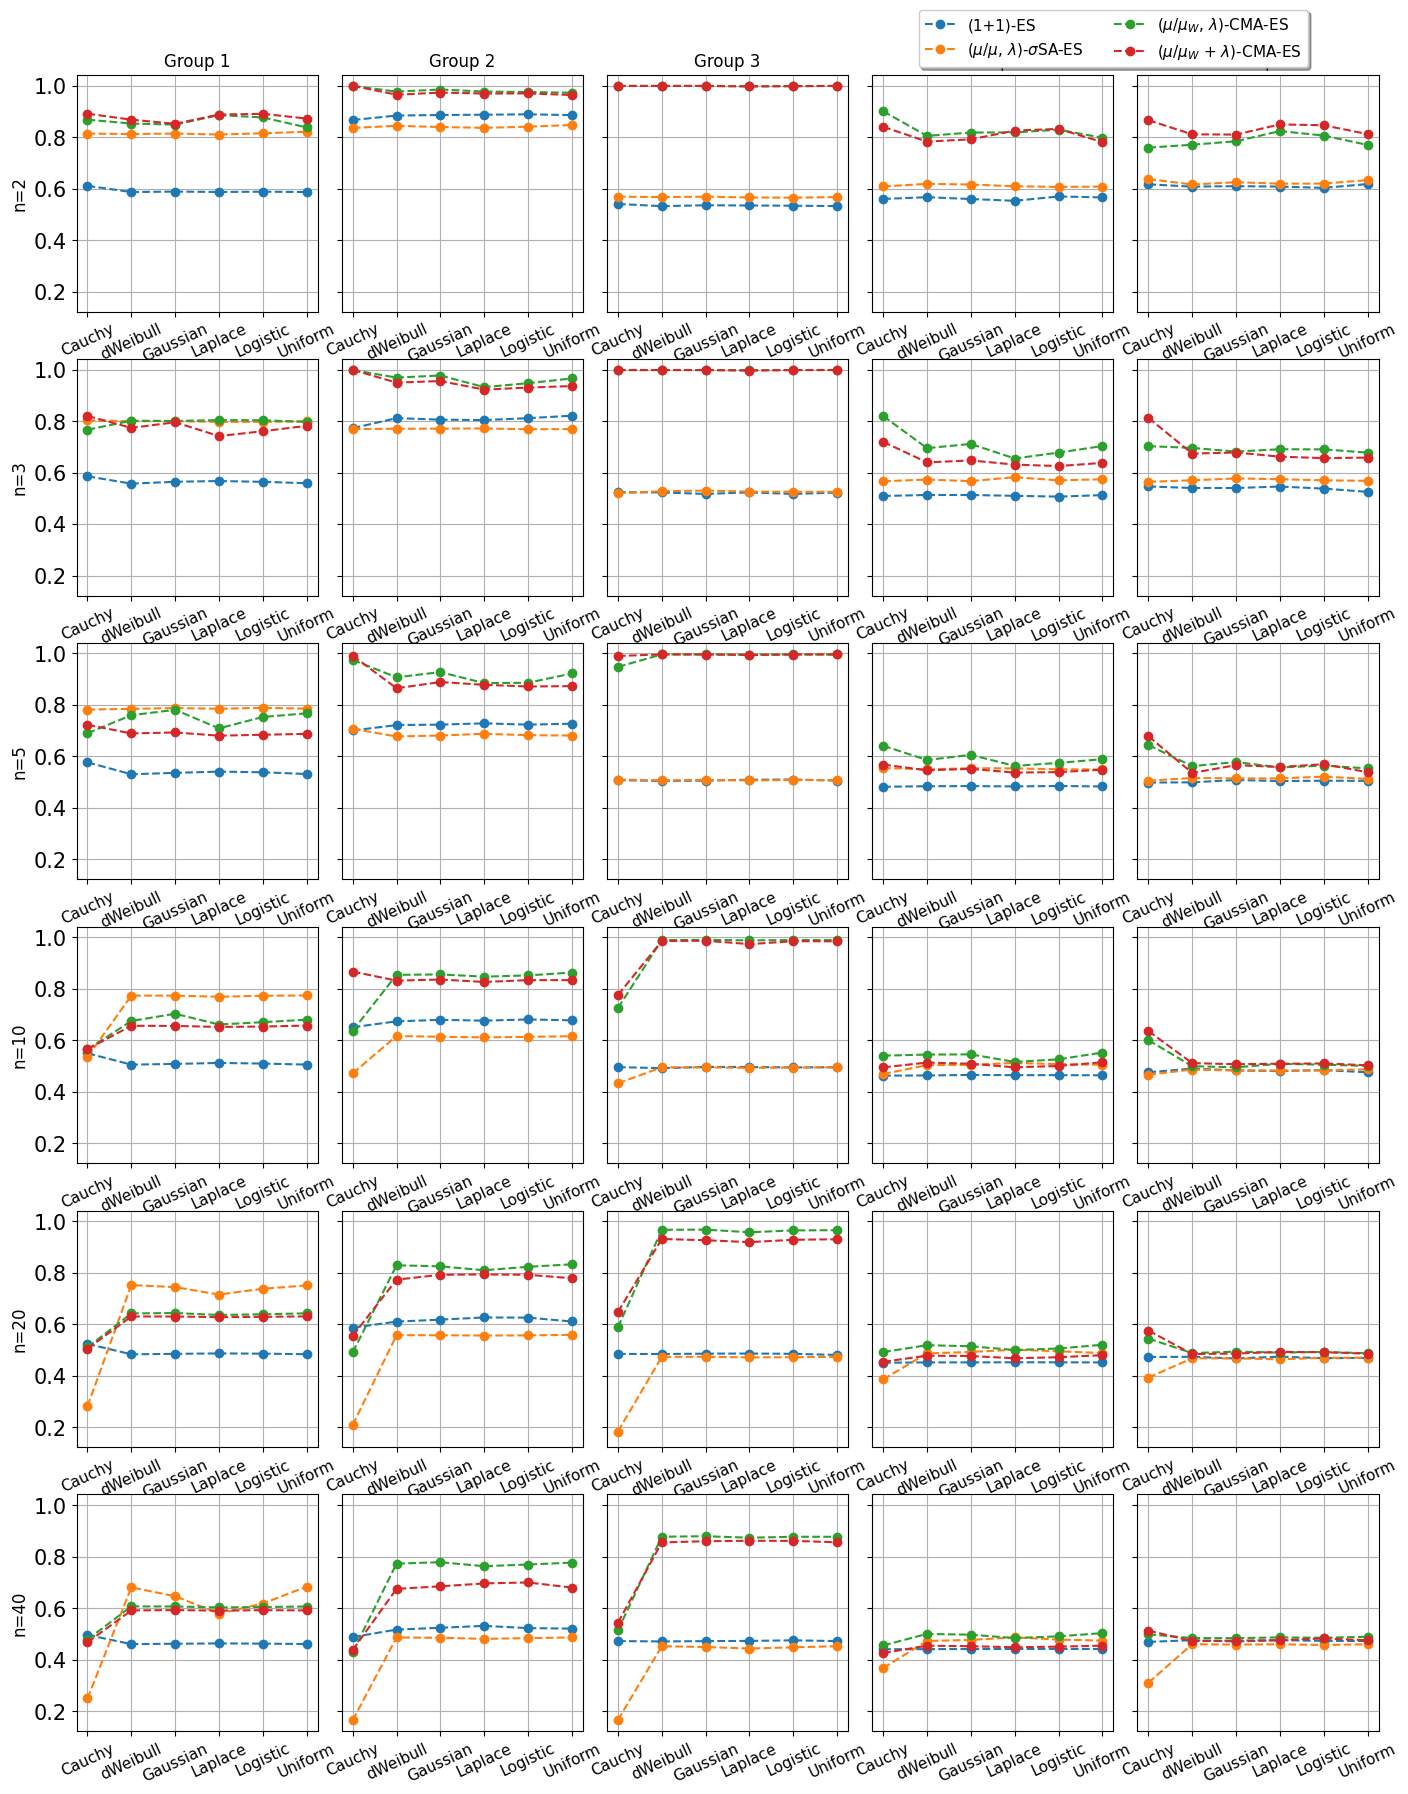

In [146]:
dims = sorted(aoccs['d'].unique())
f, axes = plt.subplots(len(dims), 5, figsize=(14, 12), sharey=True)

for d, axs in zip(dims, axes):
    for gi, ax in enumerate(axs.ravel(), 1):
        for alg in nice_alg_names:
            group = aoccs.filter(gi=gi, alg=alg, d=d)
            idx = np.argsort(group['sampler'])
            ax.plot(group['sampler'][idx], group['aocc'][idx], label=nice_alg_names[alg], marker='o', linestyle='dashed')
        
        if d == 2:
            ax.set_title(f"Group {gi}", fontsize=12)
            if gi == 5: 
                h, l = ax.get_legend_handles_labels()   
                ax.legend(np.array(h), np.array(l), loc='lower center',
                        fontsize=11, bbox_to_anchor=(-.1, 1), fancybox=True, shadow=True, ncol=2,
                )
                
        ax.set_xticks(range(len(samplers)), labels=[x.title().replace("Double_", "d").replace("Scaled_", "") for x in samplers], rotation=25, fontsize=11)
        ax.grid()
        if gi == 1:
            ax.set_ylabel(f"n={d}", fontsize=12)
           
            
#     ax.grid()
#     ax.set_title(f"Group {gi}", fontsize=12)
    
plt.subplots_adjust(wspace=0.1, bottom=-.5, left=0.05, right=.98)
# plt.savefig("figures/auc_per_group.pdf")


NameError: name 'aoccs' is not defined

In [ ]:
import pandas as pd
manager = ins.DataManager()

algs = []
for alg in one_plus_one + mu_comma + cma_es:
    algs.append(os.path.basename(alg))
    manager.add_folder(alg)
    
algs.sort()

def get_aocc(m, xmax, group_cols=["function_name", "algorithm_name"]):
    dt_loaded = m.load(True, True)
    x_values = ins.get_sequence(1, xmax, 50, scale_log=True, cast_to_int=True)
    data_aligned = ins.align_data(dt_loaded.cast({'evaluations': pl.Int64}), evals=x_values)
    data_aocc = ins.transform_fval(data_aligned, fval_col='raw_y', maximization=False)
    return ins.get_aocc(data_aocc, xmax, group_cols=group_cols).group_by(group_cols).agg(pl.col("aocc_contribution").mean().alias("AOCC")).to_pandas()


aoccs = []
for fid in range(1, 25):
    print(fid, end=',')
    for dim, ax in zip((2, 3, 5, 10, 20), axes.ravel()):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            m = manager.select(function_ids=[fid], dimensions=[dim])

        aocc = get_aocc(m, xmax=dim * 10_000)
        aocc['dim'] = dim
        aocc['fid'] = fid
        aocc['sampler'] = aocc['algorithm_name'].str.rsplit('-', n=2, expand=True)[2]
        aocc['algorithm'] = aocc['algorithm_name'].str.rsplit('-', n=2, expand=True)[0]
        aoccs.append(aocc.drop('algorithm_name', axis=1))

aocc = pd.concat(aoccs)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,

In [ ]:
import pandas as pd
aocc = pd.read_pickle("aocc.pkl")

In [ ]:

dats = []
for alg in 'CMA-ES', 'MuCommaLambda', 'OnePlusOne',:
    gdata = aocc[aocc['algorithm'] == alg].copy()
    gdata.loc[:, 'AOCC'] = 1.0 - gdata['AOCC'].copy()
    dats.append(gdata)
    
dats = pd.concat(dats)
ratings = ins.get_glicko2_ratings(pl.DataFrame(dats), alg_vars=['algorithm', 'sampler'], fid_vars=['fid', 'dim'], perf_var='AOCC', nrounds=50)
print(ratings)


        Rating  Deviation      algorithm         sampler
0   788.492456   60.71269         CMA-ES         LAPLACE
1   771.179693  58.817398         CMA-ES        LOGISTIC
2   797.890659  57.539307         CMA-ES  SCALED_UNIFORM
3   818.899039    59.0994         CMA-ES        GAUSSIAN
4   358.120992  47.274725         CMA-ES          CAUCHY
5   823.832633  58.604902         CMA-ES  DOUBLE_WEIBULL
6   337.039054  54.418724  MuCommaLambda          CAUCHY
7   625.258801   44.27384  MuCommaLambda         LAPLACE
8   629.292639  44.236762  MuCommaLambda        GAUSSIAN
9   624.545671  44.346981  MuCommaLambda        LOGISTIC
10  628.296519  44.448611  MuCommaLambda  DOUBLE_WEIBULL
11  612.470589  44.068657  MuCommaLambda  SCALED_UNIFORM
12  489.166488   43.88901     OnePlusOne  SCALED_UNIFORM
13  501.069236   43.80594     OnePlusOne         LAPLACE
14  476.795571  43.720561     OnePlusOne        LOGISTIC
15  493.884089  43.665619     OnePlusOne        GAUSSIAN
16  454.714621  43.706829     O

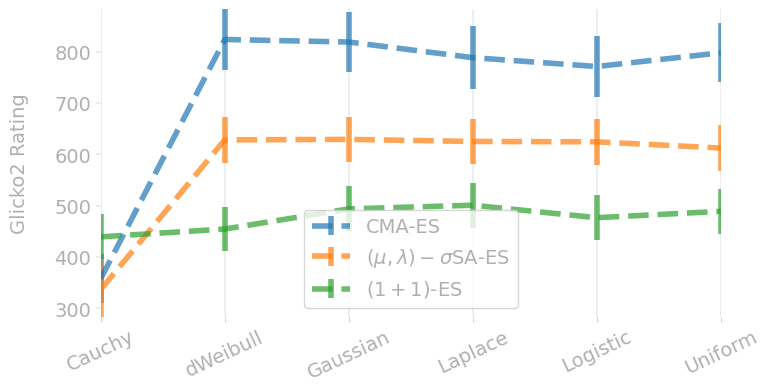

In [ ]:
plt.figure(figsize=(8, 4))

nice_labs = {
    "MuCommaLambda": r"$(\mu,\lambda)-\sigma$SA-ES",
    "CMA-ES": "CMA-ES",
    "OnePlusOne": r"$(1+1)$-ES",
}

for alg in 'CMA-ES', 'MuCommaLambda', 'OnePlusOne',:
    rats = ratings[ratings.algorithm == alg]
    idx = np.argsort(rats.sampler)
    plt.errorbar(
        rats.sampler.array[idx], 
        rats.Rating.array[idx], 
        rats.Deviation.array[idx], 
        label=nice_labs[alg], 
        linestyle='dashed', 
        linewidth=4, 
        alpha=.7
    )


plt.xticks(range(len(labels)), labels=[x.title().replace("Double_", "d").replace("Scaled_", "") for x in rats.sampler.array[idx]], rotation=25)
plt.ylabel("Glicko2 Rating")
plt.legend()
plt.grid()




/home/jacob/code/ModularCMAES/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

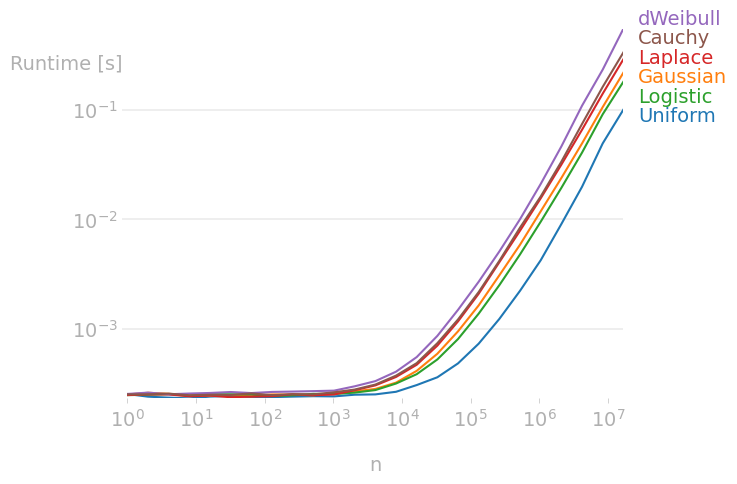

In [ ]:
import perfplot
from scipy import stats


perfplot.show(
    setup=lambda n: n,
    kernels=[
        lambda a: stats.uniform().rvs(size=a),
        lambda a: stats.norm().rvs(size=a),
        lambda a: stats.logistic().rvs(size=a),
        lambda a: stats.laplace().rvs(size=a),
        lambda a: stats.dweibull(2.0, scale=1).rvs(size=a),
        lambda a: stats.cauchy(2.0, scale=1).rvs(size=a),
    ],
    labels=["Uniform", "Gaussian", "Logistic", "Laplace", "dWeibull", "Cauchy"],
    n_range=[2**k for k in range(25)],
    xlabel="n",
    equality_check=None
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

In [34]:

samplers = [
    lambda a: stats.cauchy(2.0, scale=1).rvs(size=a),
    lambda a: stats.dweibull(2.0, scale=1).rvs(size=a),
    lambda a: stats.norm().rvs(size=a),
    lambda a: stats.laplace().rvs(size=a),
    lambda a: stats.logistic().rvs(size=a),
    lambda a: stats.uniform().rvs(size=a),
]

labels=["Cauchy", "dWeibull", "Gaussian",  "Laplace", "Logistic", "Uniform"]

def time_sampler(sampler, n = 1_000_000):
    start = perf_counter()
    sampler(n)
    return perf_counter() - start

t = []
for label, sampler in zip(labels, samplers):
    times = [time_sampler(sampler) for _ in range(1000)]
    t.append((label, np.mean(times), np.std(times)))
    
time_data = pl.DataFrame(t, schema=['sampler', 'mean', 'std'], orient='row')



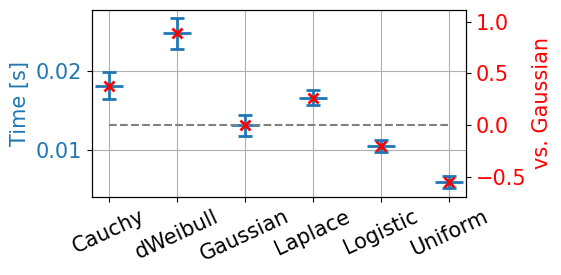

In [89]:
plt.figure(figsize=(6, 3))
p = plt.errorbar(
    time_data['sampler'], time_data['mean'], time_data['std'], 
    marker='_', markersize=20, 
    capsize=5,
    markeredgewidth=2, 
    elinewidth=2, 
    linestyle=''
)

# plt.fill_between(time_data['sampler'], time_data['mean'] - time_data['std'], time_data['mean'] + time_data['std'], color=p[0].get_color(), alpha=.5)
# plt.plot(time_data['sampler'], time_data['mean'] + time_data['std'], color=p[0].get_color(), alpha=.5)
# plt.plot(time_data['sampler'], time_data['mean'] - time_data['std'], color=p[0].get_color(), alpha=.5)

plt.grid()
plt.xticks(rotation=25);
plt.ylabel("Time [s]", color=p[0].get_color())
plt.yticks(color=p[0].get_color())
ax1 = plt.gca()
ax2 = plt.twinx()
g_time = time_data.filter(sampler='Gaussian')['mean'] 


ax2.plot(time_data['sampler'], (time_data['mean'] - g_time) / g_time, color='red', marker='x', linestyle='', markersize=7, markeredgewidth=2)

ax2.set_ylabel("vs. Gaussian", color='red')
ax2.plot(time_data['sampler'], np.zeros(6), linestyle='dashed', zorder=-100, color='grey')
plt.yticks(color='red')
ax2.set_ylim(*((np.array(ax1.get_ylim()) - g_time[0]) / g_time[0]))
plt.tight_layout()
plt.savefig("figures/time.pdf")

In [80]:
(np.array(ax1.get_ylim()) - g_time[0]) / g_time[0]

array([-0.68929108,  1.1114529 ])